In [1]:
from google.colab import files
uploaded = files.upload()


Saving sp_400_midcap1.csv to sp_400_midcap1.csv


In [2]:
import requests
import pandas as pd

class StockData:
    """
    A class to fetch and process stock data from the EOD Historical Data API.
    """
    def __init__(self, csv_file_path: str, api_key: str) -> None:
        """
        Initialize the StockData object by loading ticker symbols and sectors from a CSV file.
        """
        # Load ticker names and sectors from the uploaded CSV file
        self.ticker_names = pd.read_csv(csv_file_path)['Symbol'].tolist()
        self.ticker_sectors = pd.read_csv(csv_file_path)['GICS Sector'].tolist()
        self.ticker_info = dict(zip(self.ticker_names, self.ticker_sectors))
        self.api_key = api_key
        self.base_url = 'https://eodhd.com/api/eod'

    def _fetch_data(self, ticker: str, period: str, start: str, end: str):
        '''
        Private method to fetch stock data for a single ticker symbol from the API.
        '''
        url = f"{self.base_url}/{ticker}.US?period={period}&from={start}&to={end}&api_token={self.api_key}&fmt=json"
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Failed to fetch data for {ticker}: {response.status_code}")
            return None

    def fetch_stock(self, ticker: str, period: str, start: str, end: str) -> pd.DataFrame:
        """
        Fetches stock data for a single ticker and returns it as a pandas DataFrame.
        """
        print(f"Fetching data for {ticker}...")
        result = self._fetch_data(ticker, period, start, end)
        df = pd.DataFrame(result)
        return df

    def fetch_stocks_by_sectors(self, sector: str, period: str, start: str, end: str) -> pd.DataFrame:
        """
        Fetches stock data for all tickers in a specific GICS sector and returns a merged DataFrame.
        """
        results = {}
        for ticker, s in self.ticker_info.items():
            if s == sector:
                results[ticker] = pd.DataFrame(self._fetch_data(ticker, period, start, end))

        all_data = self._process_merge_all_data(results)
        return all_data

    def fetch_all_stocks(self, period: str, start: str, end: str):
        '''
        Fetches stock data for all tickers and returns a merged DataFrame.
        '''
        results = {}
        for ticker in self.ticker_info.keys():
            results[ticker] = pd.DataFrame(self._fetch_data(ticker, period, start, end))

        all_data = self._process_merge_all_data(results)
        return all_data

    def _process_merge_all_data(self, dic:dict) -> pd.DataFrame:
        '''
        Private method to process and merge stock data from multiple tickers into a single DataFrame.
        '''
        all_data = []

        for name, df in dic.items():
            if df.empty:
                print(f"No data for {name}. Skipping...")
                continue

            df['date'] = pd.to_datetime(df['date'])
            df['ticker'] = name
            all_data.append(df)

        full_data = pd.concat(all_data)

        full_data.set_index(['date', 'ticker'], inplace=True)

        return full_data


# Run the code in the main block
if __name__ == "__main__":
    # Use the name of the uploaded file
    csv_file_path = "sp_400_midcap1.csv"  # Ensure this matches the name of the uploaded file
    api_key = '662166cb8e3d13.57537943'  # Replace with your actual API key

    # Initialize StockData with uploaded CSV file path and API key
    stock = StockData(csv_file_path, '662166cb8e3d13.57537943')

    # Fetch all stock data (example)
    df = stock.fetch_all_stocks(period='d', start='2000-01-01', end='2024-08-30')
    print(df.head())
    print(df.shape)


                      open     high      low    close  adjusted_close   volume
date       ticker                                                             
2000-01-03 AA      83.0000  83.5624  80.3750  80.9375         69.8640  1291386
2000-01-04 AA      80.9375  81.8125  80.3125  81.3125         70.1877  1860008
2000-01-05 AA      81.3125  86.5000  81.0000  86.0000         74.2338  2598086
2000-01-06 AA      86.0000  86.3750  84.8125  84.8750         73.2627  3740907
2000-01-07 AA      84.8750  86.8750  84.5624  84.6250         73.0469  3774199
(1964002, 6)


In [3]:
from google.colab import files
uploaded = files.upload()  # Upload the 'sp_400_midcap1.csv' file

import pandas as pd

# Step 1: Automatically set `sector_info_path` to the uploaded file's name
sector_info_path = list(uploaded.keys())[0]  # Get the filename dynamically

# Assuming `df` is the DataFrame that contains your stock data with 'date' and 'ticker' indices

# Reset the index without adding duplicate index columns
df = df.reset_index()

# Read the sector information from the uploaded file
sector_info = pd.read_csv(sector_info_path)

# Select only the 'Symbol' and 'GICS Sector' columns
sector_info = sector_info[['Symbol', 'GICS Sector']]

# Merge on 'ticker' in df and 'Symbol' in sector_info
df_merged = pd.merge(df, sector_info, left_on='ticker', right_on='Symbol', how='left')

# Drop the redundant 'Symbol' column after merging
df_merged = df_merged.drop(columns=['Symbol'])

Saving sp_400_midcap1.csv to sp_400_midcap1 (1).csv


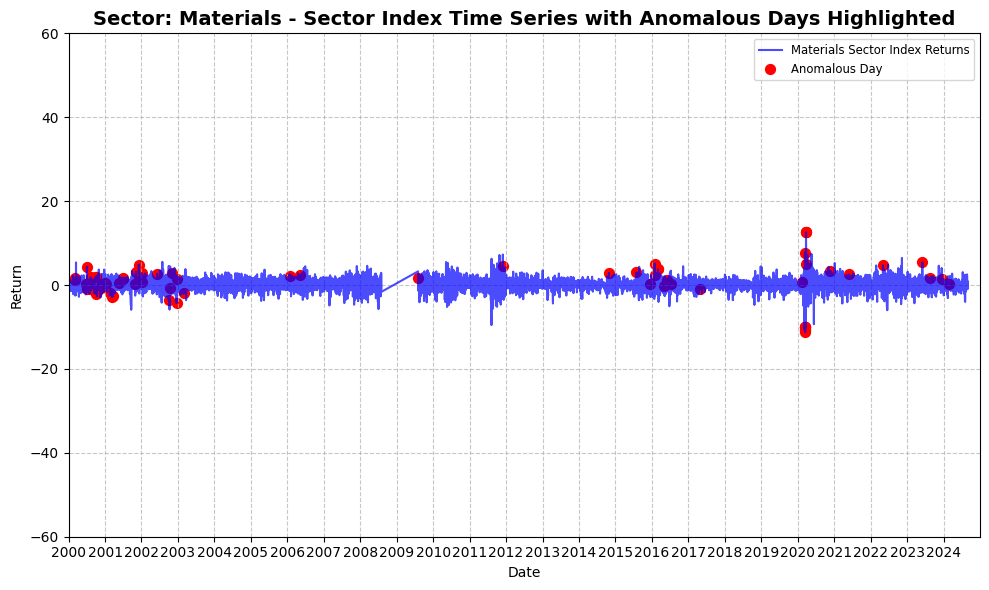

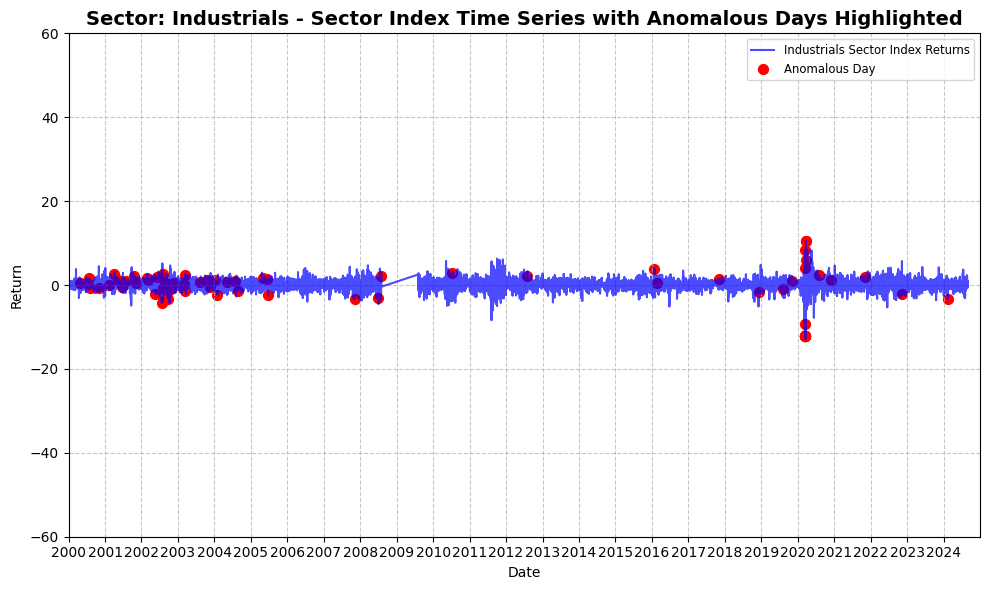

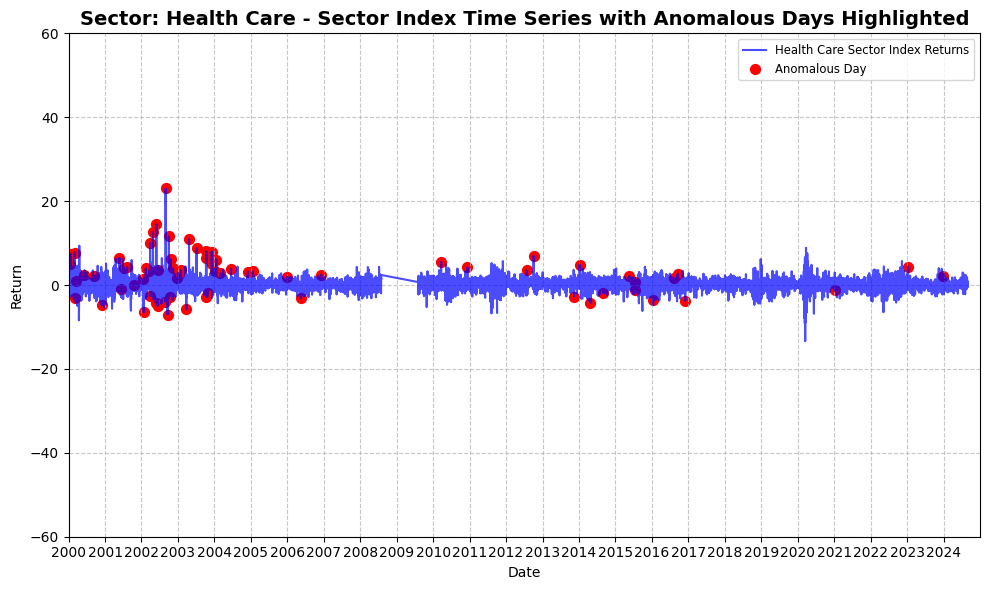

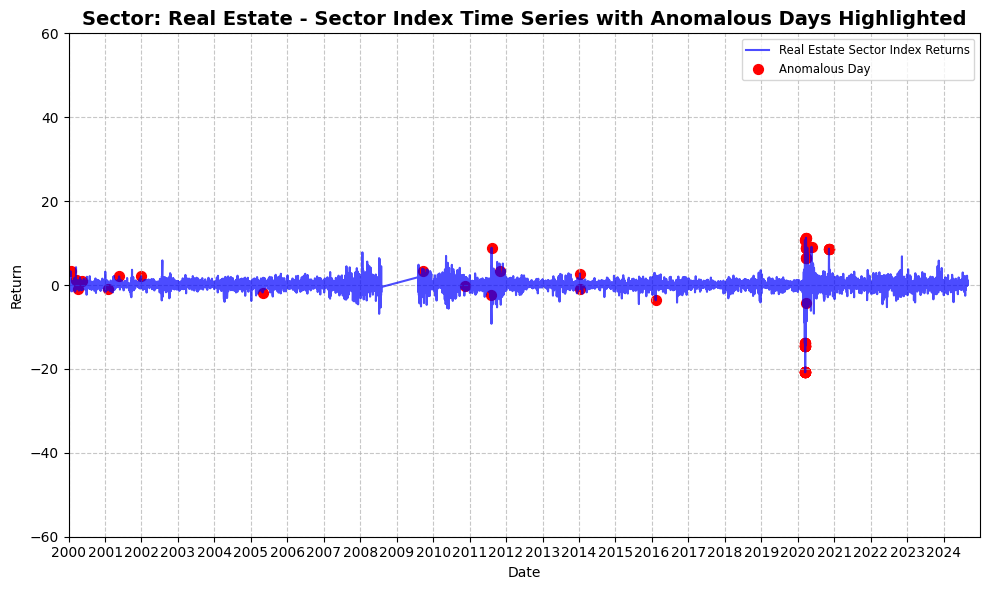

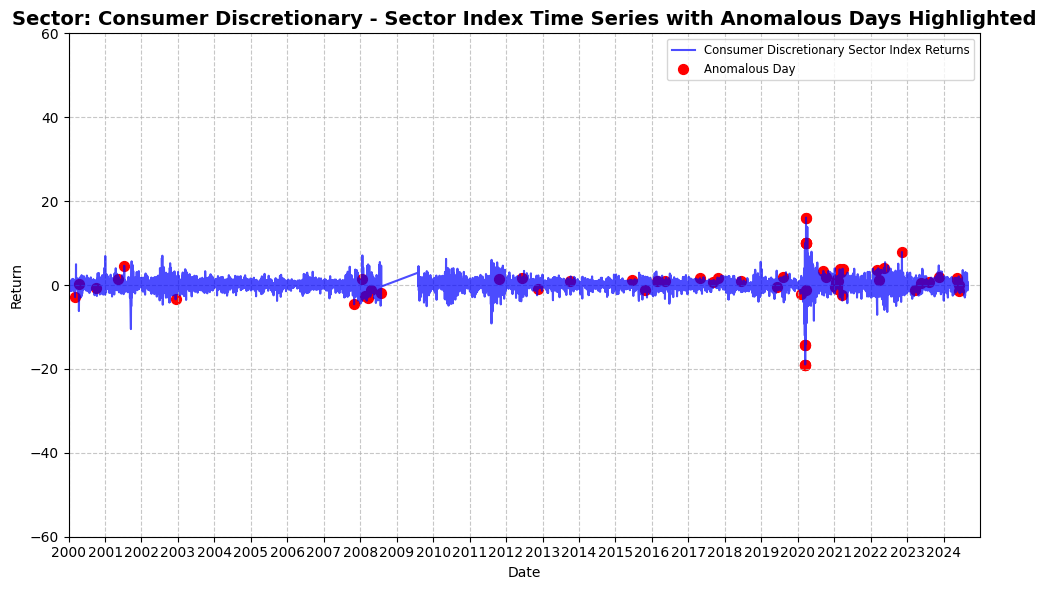

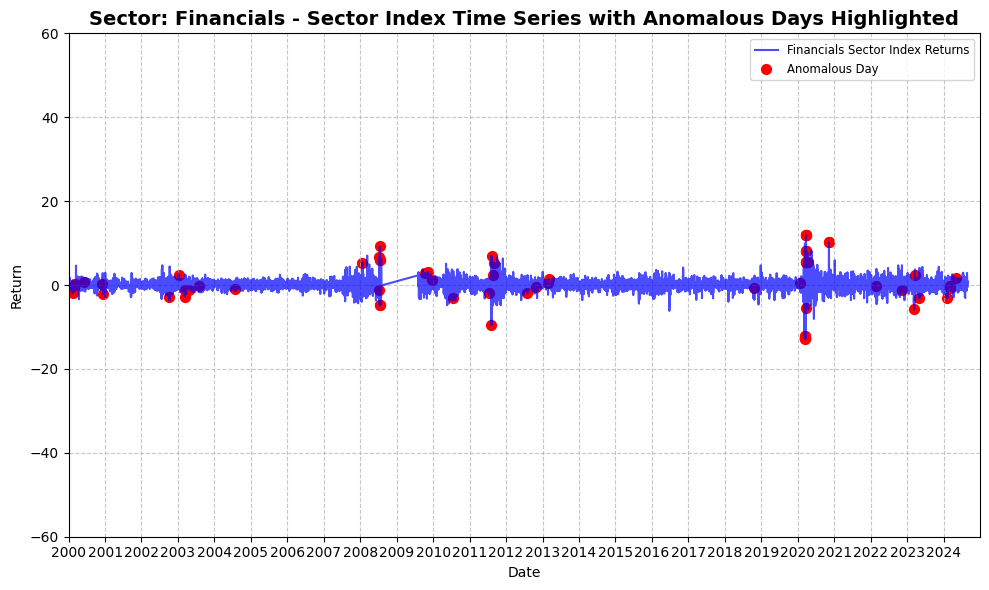

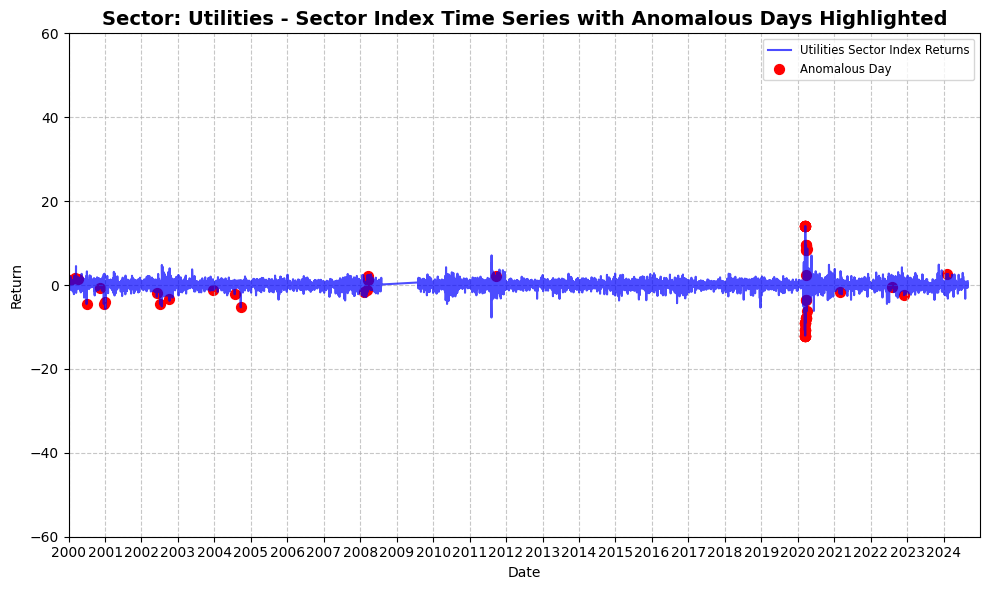

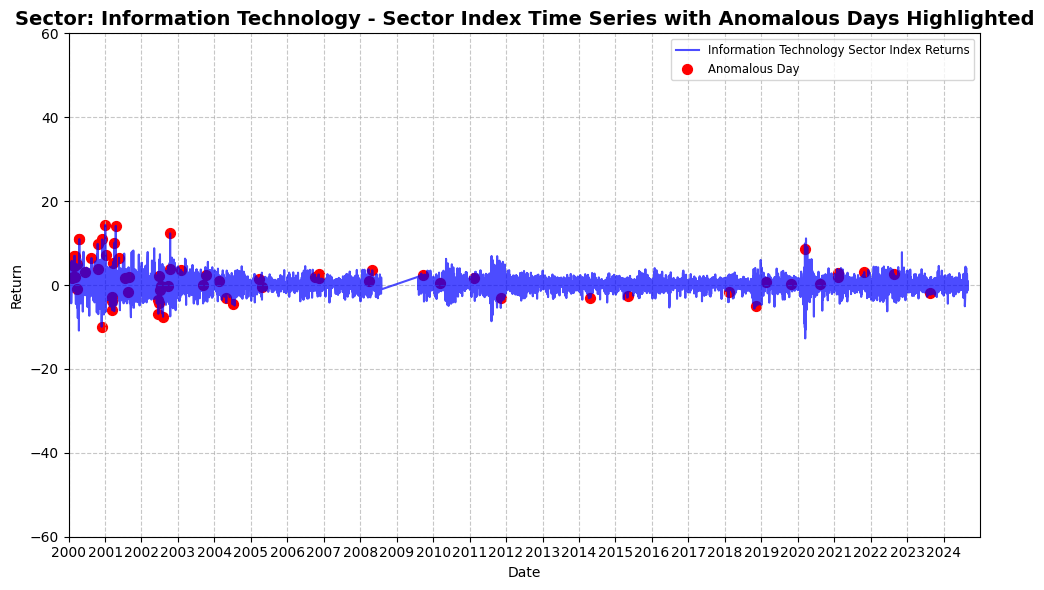

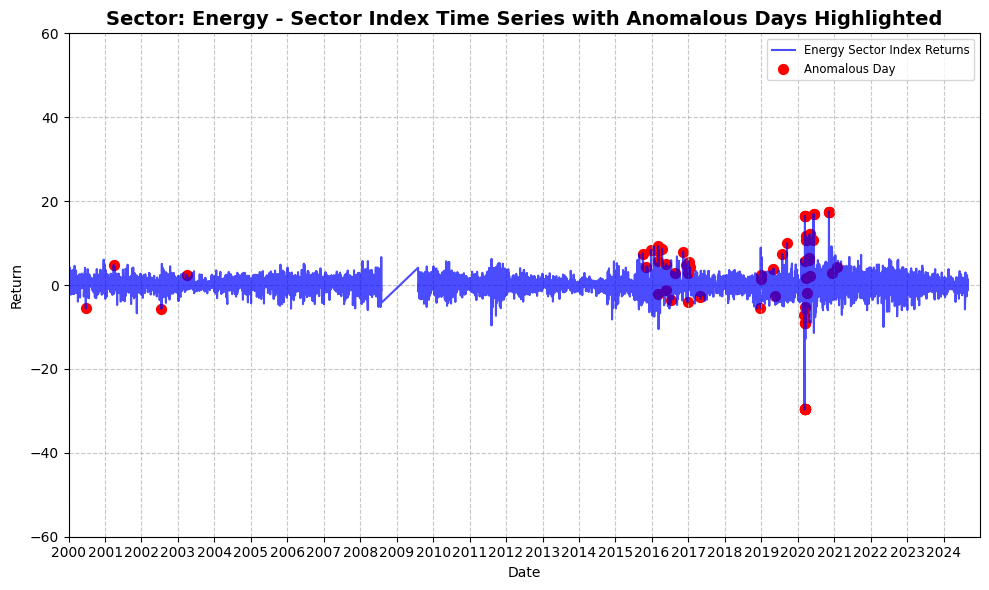

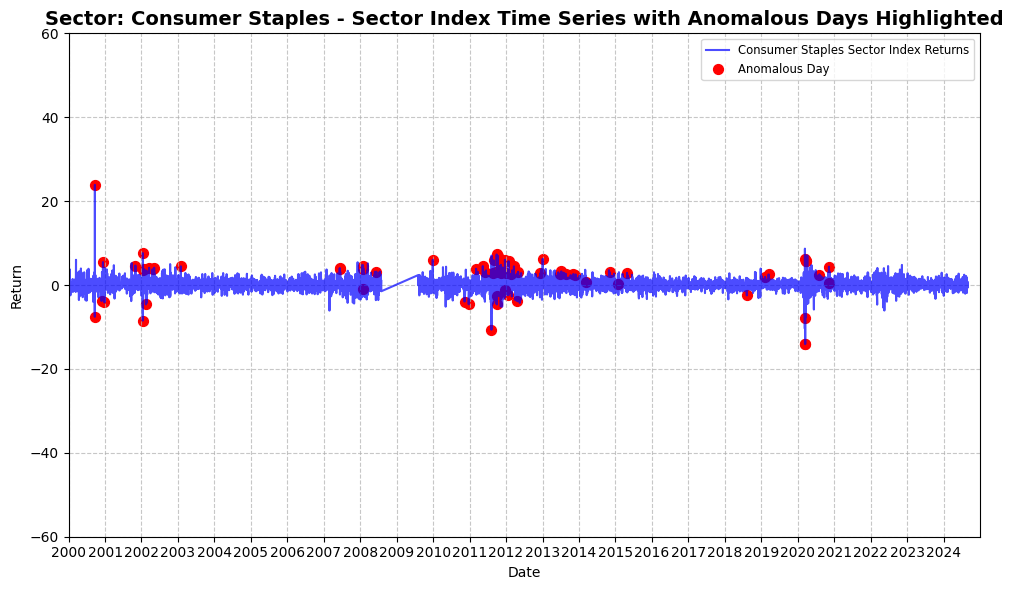

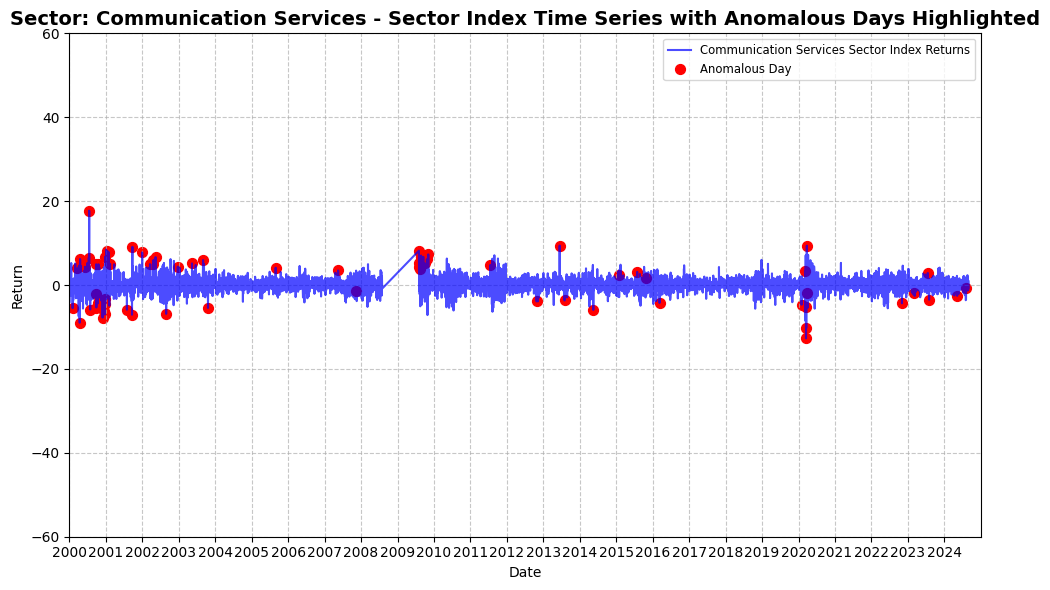

Anomalies data saved to 'all_anomalies_excluded_period.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.spatial.distance import mahalanobis

# Ensure 'date' is in datetime format
df_merged['date'] = pd.to_datetime(df_merged['date'], errors='coerce')
df_merged.dropna(subset=['date'], inplace=True)

# Calculate daily returns for each stock
df_merged['return'] = df_merged.groupby('ticker')['adjusted_close'].pct_change() * 100
df_merged.dropna(subset=['return'], inplace=True)

# Define the exclusion period
exclusion_start = pd.Timestamp('2008-08-01')
exclusion_end = pd.Timestamp('2009-08-01')

# Function to calculate stable mean and covariance for the entire sector
def calculate_stable_mean_cov(sector_df):
    sector_returns = sector_df.pivot(index='date', columns='ticker', values='return').dropna()
    mean_vector = sector_returns.mean().values
    cov_matrix = np.cov(sector_returns.T)
    cov_inv = np.linalg.inv(cov_matrix)
    return mean_vector, cov_inv, sector_returns.columns

# Function to calculate anomalies using the stable mean and covariance across pairs
def calculate_multidimensional_anomalies(sector_df, mean_vector, cov_inv, sector_columns):
    anomalies = []

    for ticker in sector_columns:
        # Filter out the exclusion period
        ticker_df = sector_df[(sector_df['ticker'] == ticker) &
                              ~((sector_df['date'] >= exclusion_start) & (sector_df['date'] <= exclusion_end))].dropna(subset=['return'])

        if ticker_df.empty:
            continue  # Skip if no data for the ticker

        # Calculate Mahalanobis distance for each return against the stable sector mean
        ticker_df['anomaly_score'] = ticker_df['return'].apply(
            lambda x: mahalanobis([x], mean_vector, cov_inv)
        )

        anomalies.append(ticker_df[['date', 'ticker', 'anomaly_score']])

    # Combine all anomalies and sort by score
    all_anomalies = pd.concat(anomalies).sort_values(by='anomaly_score', ascending=False)

    # Select the top 70 highest anomalies
    top_anomalies = all_anomalies.nlargest(70, 'anomaly_score')

    return top_anomalies

# Prepare to collect anomalies for plotting and final output
top_anomalies_per_sector = {}

# Calculate anomalies for each sector by analyzing stock pairs
for sector in df_merged['GICS Sector'].unique():
    sector_df = df_merged[df_merged['GICS Sector'] == sector].copy()
    stable_mean, stable_cov_inv, sector_columns = calculate_stable_mean_cov(sector_df)

    top_sector_anomalies = calculate_multidimensional_anomalies(sector_df, stable_mean, stable_cov_inv, sector_columns)
    top_anomalies_per_sector[sector] = top_sector_anomalies  # Store top anomalies for this sector

# Aggregate daily returns for each sector excluding the specified period
sector_daily_returns = {}
for sector, sector_df in df_merged.groupby('GICS Sector'):
    # Filter out dates in the exclusion period
    sector_df = sector_df[(sector_df['date'] < exclusion_start) | (sector_df['date'] > exclusion_end)]
    sector_df = sector_df.pivot_table(index='date', values='return', aggfunc='mean')
    sector_daily_returns[sector] = sector_df

# Save all anomalies to a CSV file
all_anomalies_combined = pd.concat(top_anomalies_per_sector.values())
all_anomalies_combined.to_csv("all_anomalies_excluded_period.csv", index=False)

# Plot each sector's time series and mark anomalies
for sector, top_anomalies in top_anomalies_per_sector.items():
    plt.figure(figsize=(10, 6))
    plt.title(f"Sector: {sector} - Sector Index Time Series with Anomalous Days Highlighted", fontsize=14, fontweight='bold')

    # Plot the sector's average daily return time series as a sector index
    sector_df = sector_daily_returns[sector]
    plt.plot(sector_df.index, sector_df['return'], color='blue', alpha=0.7, label=f'{sector} Sector Index Returns')

    # Highlight anomaly dates on the sector time series
    anomaly_dates = top_anomalies['date'].unique()  # Unique anomaly dates
    anomaly_scores = top_anomalies[top_anomalies['date'].isin(anomaly_dates)]
    plt.scatter(anomaly_scores['date'], sector_df.loc[anomaly_scores['date'], 'return'], color='red', s=50, label='Anomalous Day')

    # Customize each plot
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim([pd.Timestamp('2000-01-01'), pd.Timestamp('2024-12-31')])
    plt.ylim(-60, 60)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Add a legend
    plt.legend(loc='best', fontsize='small')

    # Adjust layout for neat spacing
    plt.tight_layout()
    plt.show()

# Display a message to inform the user
print("Anomalies data saved to 'all_anomalies_excluded_period.csv'.")

# For Google Colab, you can add this to download the file directly
from google.colab import files
files.download("all_anomalies_excluded_period.csv")


In [5]:
print("All anomalies across sectors (stock name, date, and anomaly score):")
for sector, top_anomalies in top_anomalies_per_sector.items():
    print(f"\nSector: {sector}")
    print(top_anomalies)



All anomalies across sectors (stock name, date, and anomaly score):

Sector: Materials
              date ticker  anomaly_score
149474  2002-12-18   AVNT      63.639668
286803  2001-12-05    CCK      57.315356
286783  2001-11-06    CCK      55.703756
740719  2000-07-03    GPK      52.131389
354261  2016-05-31    CLF      49.892113
...            ...    ...            ...
278408  2002-06-07    CBT      27.596525
354180  2016-02-03    CLF      27.525430
1432038 2020-03-18   RGLD      27.359546
163816  2020-03-16   AXTA      26.990289
996451  2002-10-02    LPX      26.979255

[70 rows x 3 columns]

Sector: Industrials
              date ticker  anomaly_score
264679  2021-11-02    CAR     168.306351
1181361 2002-09-24    NSP     133.180751
654235  2020-03-19    FLR     118.340682
356789  2001-10-22    CLH     118.201497
357061  2002-11-19    CLH      92.203996
...            ...    ...            ...
1722684 2008-07-30   TREX      40.187541
611748  2010-07-07    FCN      40.104359
1181325 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All anomalies across sectors (stock name, date, and anomaly score):

Sector: Materials
              date ticker  anomaly_score
149474  2002-12-18   AVNT      63.538651
286803  2001-12-05    CCK      57.224585
286783  2001-11-06    CCK      55.615540
740719  2000-07-03    GPK      52.048836
354261  2016-05-31    CLF      49.813110
...            ...    ...            ...
278408  2002-06-07    CBT      27.552861
354180  2016-02-03    CLF      27.481878
1432038 2020-03-18   RGLD      27.316036
163816  2020-03-16   AXTA      26.947365
996451  2002-10-02    LPX      26.936348

[70 rows x 3 columns]

Sector: Industrials
              date ticker  anomaly_score
264679  2021-11-02    CAR     168.328671
1181361 2002-09-24    NSP     133.198913
654235  2020-03-19    FLR     118.357088
356789  2001-10-22    CLH     118.217887
357061  2002-11-19    CLH      92.217308
...            ...    ...            ...
611748  2010-07-07    FCN      40.106675
1181325 2002-08-02    NSP      40.095367
1725015 

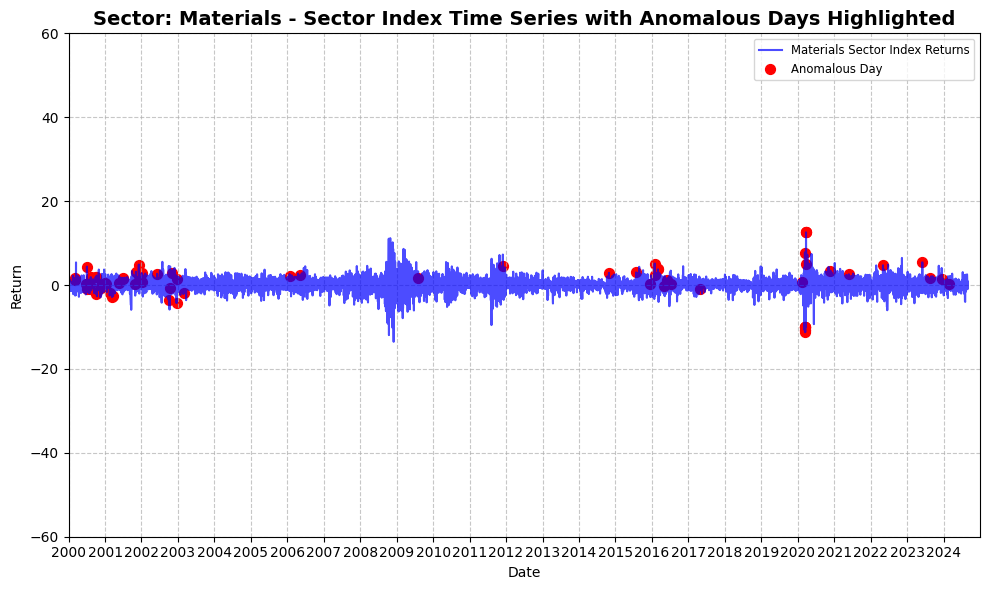

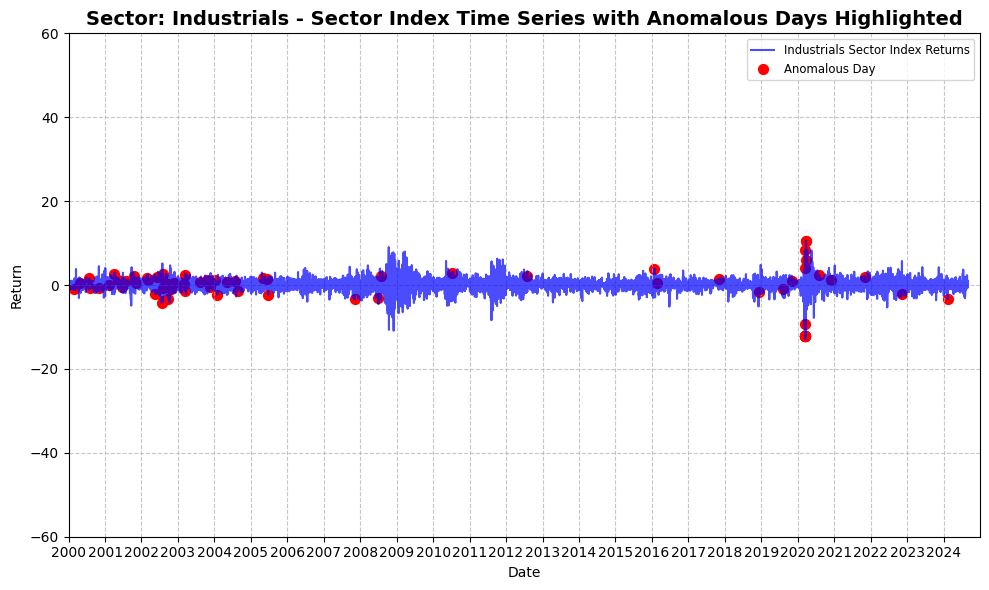

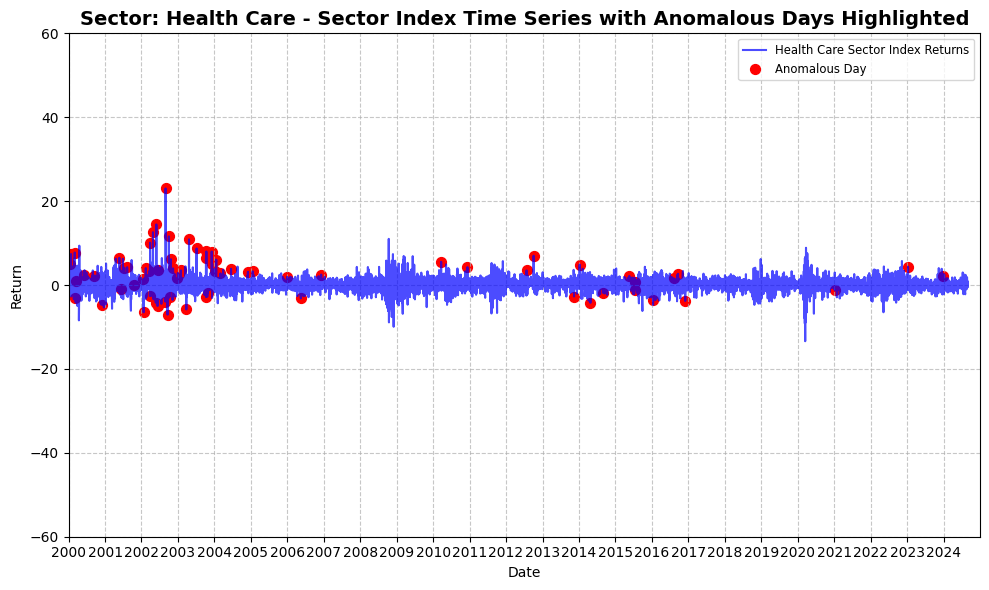

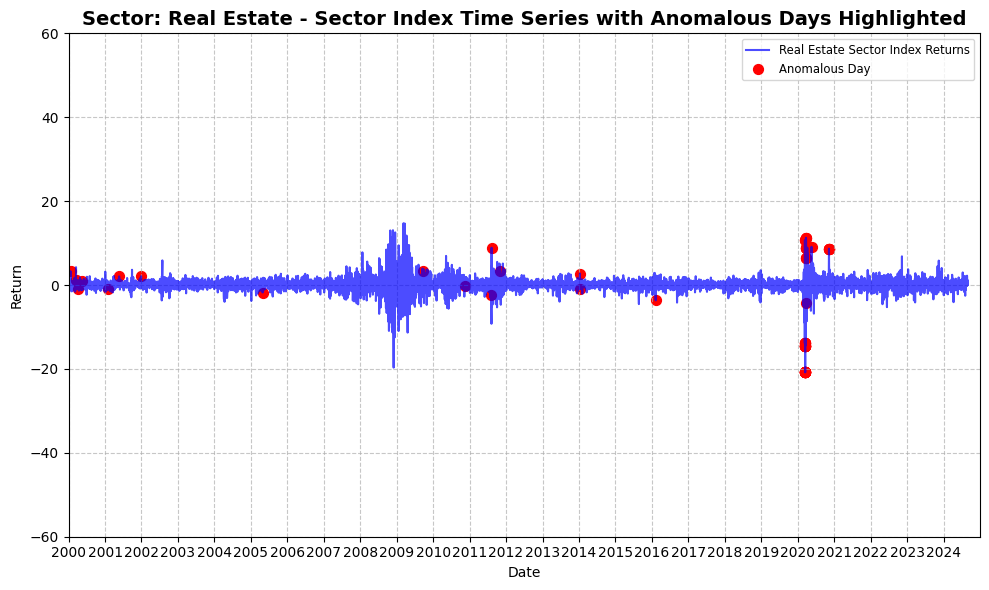

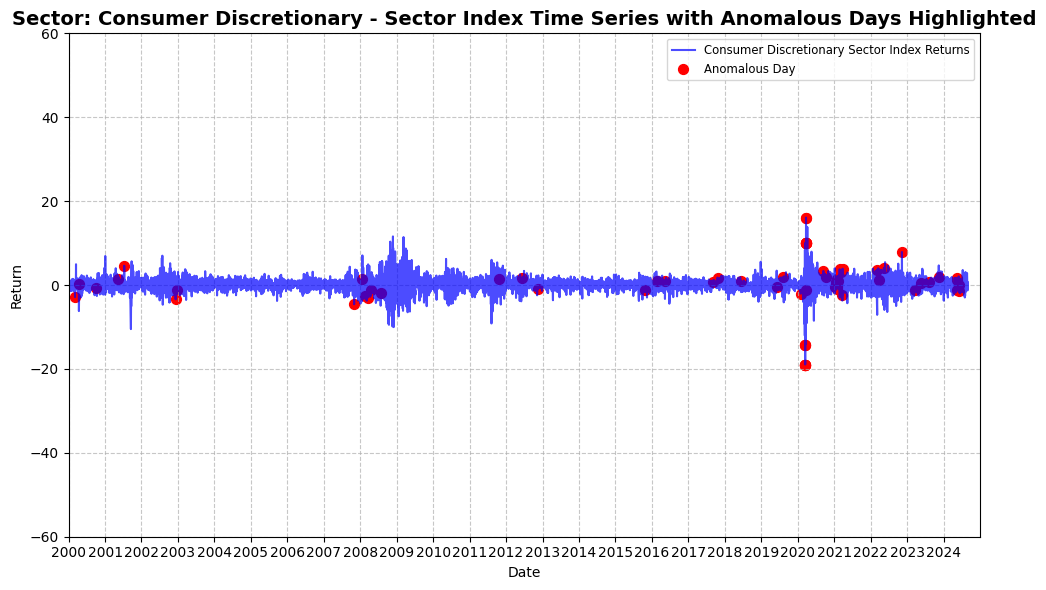

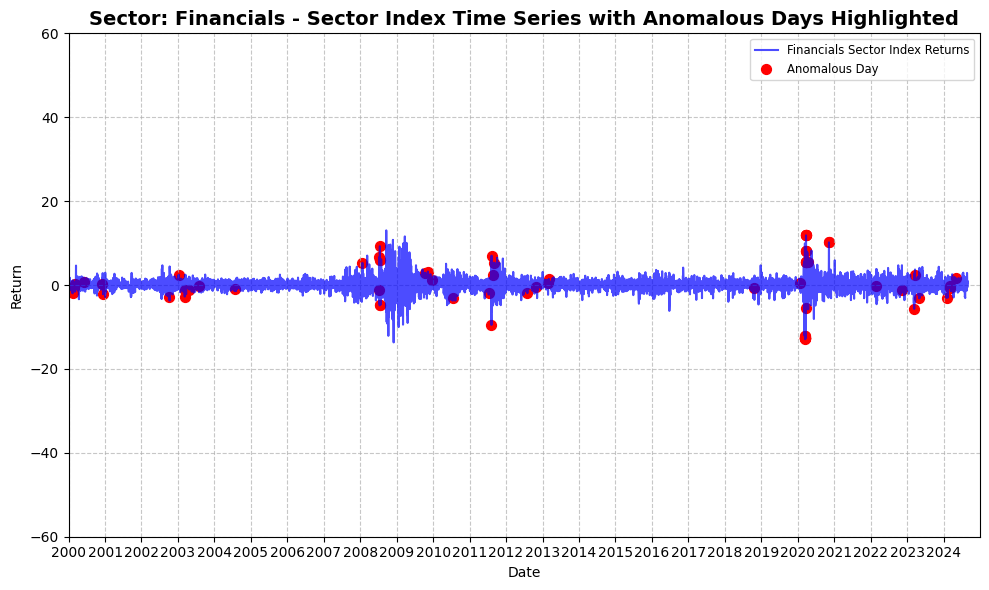

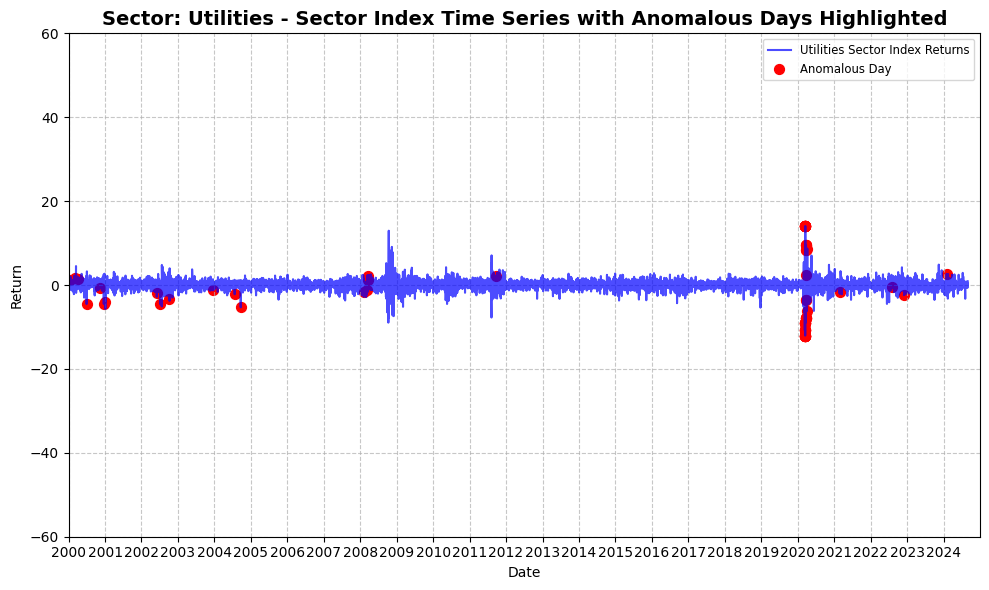

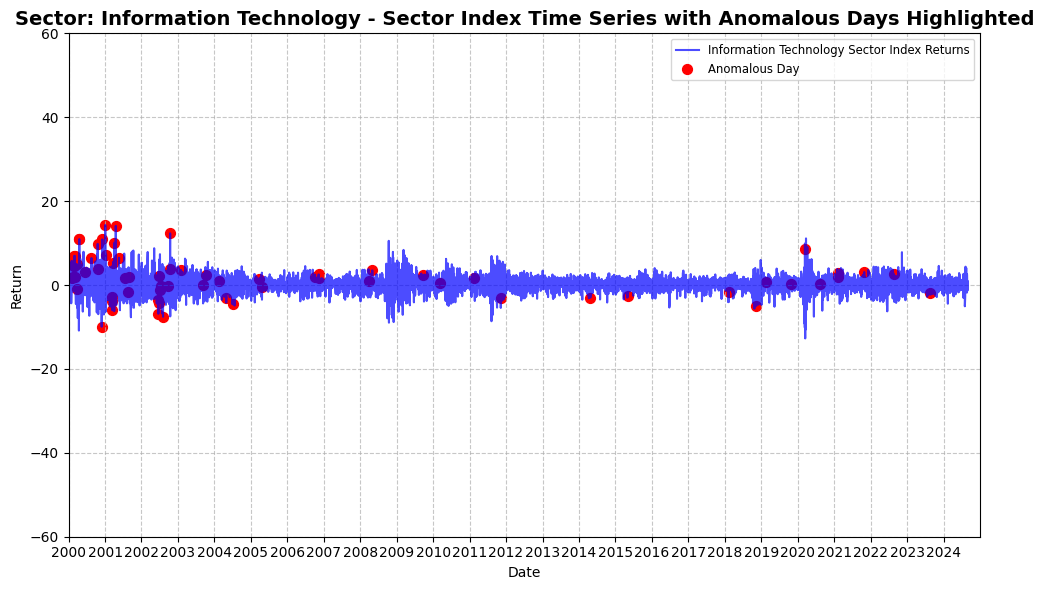

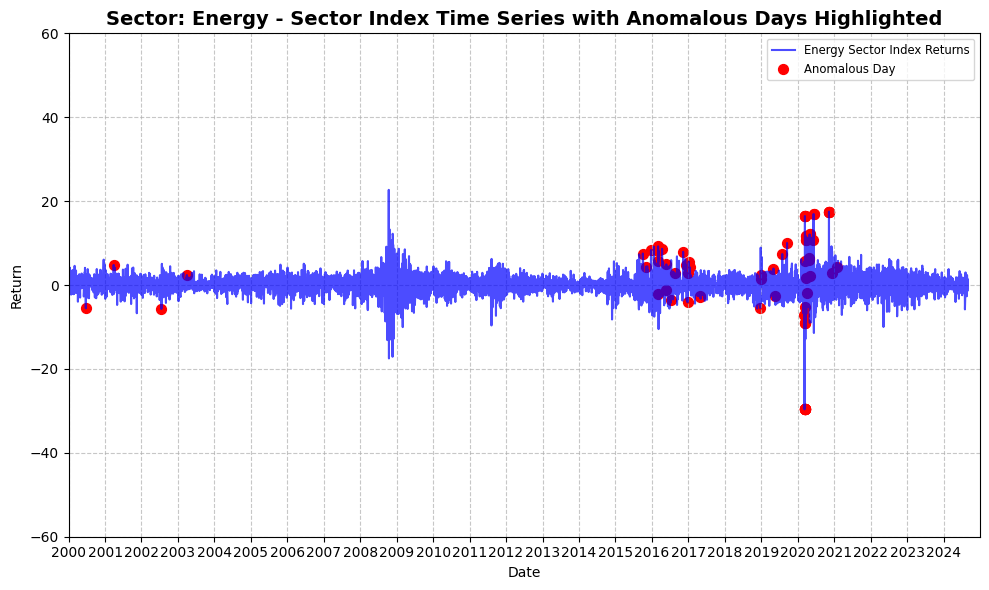

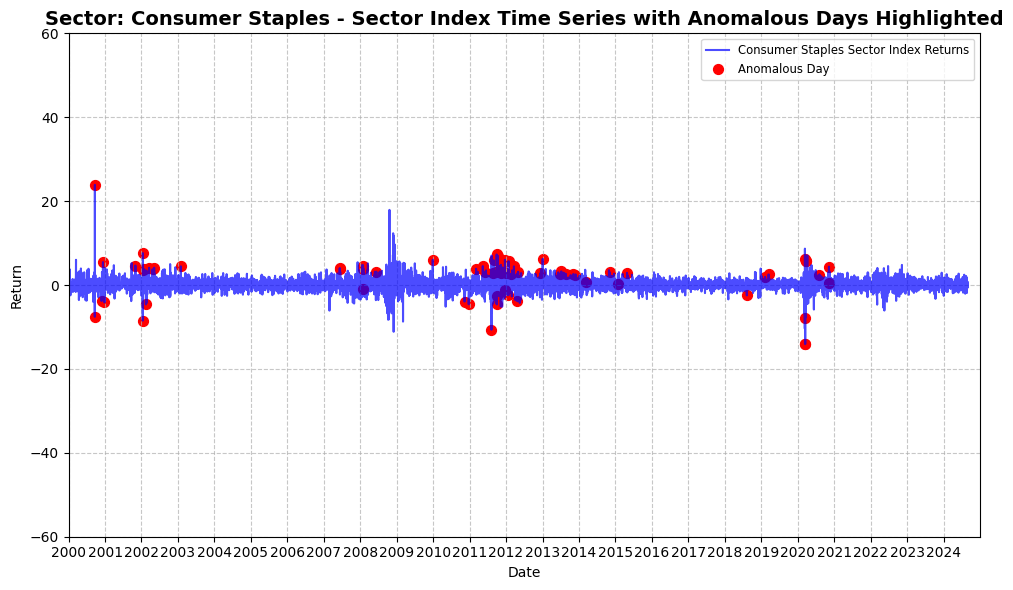

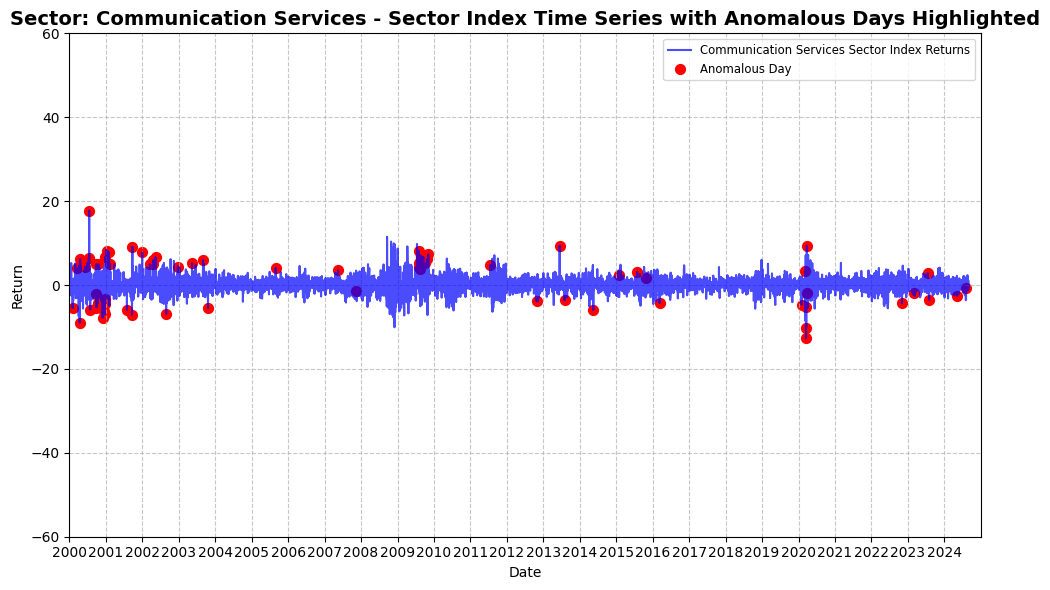

Sector-based anomaly summary saved to 'sector_anomalies_summary.csv'.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.spatial.distance import mahalanobis

# Ensure 'date' is in datetime format
df_merged['date'] = pd.to_datetime(df_merged['date'], errors='coerce')
df_merged.dropna(subset=['date'], inplace=True)

# Calculate daily returns for each stock
df_merged['return'] = df_merged.groupby('ticker')['adjusted_close'].pct_change() * 100
df_merged.dropna(subset=['return'], inplace=True)

# Define the exclusion period
exclusion_start = pd.Timestamp('2008-08-01')
exclusion_end = pd.Timestamp('2009-08-01')

# Function to calculate stable mean and covariance for the entire sector
def calculate_stable_mean_cov(sector_df):
    sector_returns = sector_df.pivot(index='date', columns='ticker', values='return').dropna()
    mean_vector = sector_returns.mean().values
    cov_matrix = np.cov(sector_returns.T)
    cov_inv = np.linalg.inv(cov_matrix)
    return mean_vector, cov_inv, sector_returns.columns

# Function to calculate anomalies using the stable mean and covariance across pairs
def calculate_multidimensional_anomalies(sector_df, mean_vector, cov_inv, sector_columns):
    anomalies = []

    for ticker in sector_columns:
        # Filter out the exclusion period
        ticker_df = sector_df[(sector_df['ticker'] == ticker) &
                              ~((sector_df['date'] >= exclusion_start) & (sector_df['date'] <= exclusion_end))].dropna(subset=['return'])

        if ticker_df.empty:
            continue  # Skip if no data for the ticker

        # Calculate Mahalanobis distance for each return against the stable sector mean
        ticker_df['anomaly_score'] = ticker_df['return'].apply(
            lambda x: mahalanobis([x], mean_vector, cov_inv)
        )

        anomalies.append(ticker_df[['date', 'ticker', 'anomaly_score']])

    # Combine all anomalies and sort by score
    all_anomalies = pd.concat(anomalies).sort_values(by='anomaly_score', ascending=False)

    # Select the top 70 highest anomalies
    top_anomalies = all_anomalies.nlargest(70, 'anomaly_score')

    return top_anomalies

# Prepare to collect anomalies for each sector
top_anomalies_per_sector = {}

# Calculate anomalies for each sector
for sector in df_merged['GICS Sector'].unique():
    sector_df = df_merged[df_merged['GICS Sector'] == sector].copy()
    stable_mean, stable_cov_inv, sector_columns = calculate_stable_mean_cov(sector_df)

    top_sector_anomalies = calculate_multidimensional_anomalies(sector_df, stable_mean, stable_cov_inv, sector_columns)
    top_anomalies_per_sector[sector] = top_sector_anomalies  # Store top anomalies for this sector

# Create a date range covering the full period in the dataset
date_range = pd.date_range(start=df_merged['date'].min(), end=df_merged['date'].max())

# Initialize an empty DataFrame for the sector-based anomaly summary
sector_anomalies_summary = pd.DataFrame(index=date_range)

# Populate the DataFrame: 1 for anomaly, 0 for no anomaly
for sector, anomalies in top_anomalies_per_sector.items():
    # Mark anomalies for this sector as 1, non-anomalies as 0
    sector_anomalies_summary[sector] = 0
    anomaly_dates = anomalies['date'].unique()
    sector_anomalies_summary.loc[anomaly_dates, sector] = 1

# Save to CSV
sector_anomalies_summary.to_csv("sector_anomalies_summary.csv")

# For Google Colab, you can add this to download the file directly
from google.colab import files
files.download("sector_anomalies_summary.csv")

# Display all anomalies with stock name, date, and anomaly score for each sector
print("All anomalies across sectors (stock name, date, and anomaly score):")
for sector, anomalies in top_anomalies_per_sector.items():
    print(f"\nSector: {sector}")
    print(anomalies)

# Plot each sector's time series and mark anomalies
for sector, top_anomalies in top_anomalies_per_sector.items():
    plt.figure(figsize=(10, 6))
    plt.title(f"Sector: {sector} - Sector Index Time Series with Anomalous Days Highlighted", fontsize=14, fontweight='bold')

    # Aggregate sector returns for sector index plot
    sector_df = df_merged[df_merged['GICS Sector'] == sector]
    sector_daily_return = sector_df.pivot_table(index='date', values='return', aggfunc='mean')

    # Plot the sector's average daily return time series as a sector index
    plt.plot(sector_daily_return.index, sector_daily_return['return'], color='blue', alpha=0.7, label=f'{sector} Sector Index Returns')

    # Highlight anomaly dates on the sector time series
    plt.scatter(top_anomalies['date'], sector_daily_return.loc[top_anomalies['date'], 'return'],
                color='red', s=50, label='Anomalous Day')

    # Customize each plot
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim([pd.Timestamp('2000-01-01'), pd.Timestamp('2024-12-31')])
    plt.ylim(-60, 60)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Add a legend
    plt.legend(loc='best', fontsize='small')

    # Adjust layout for neat spacing
    plt.tight_layout()
    plt.show()

# Display a message to inform the user
print("Sector-based anomaly summary saved to 'sector_anomalies_summary.csv'.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

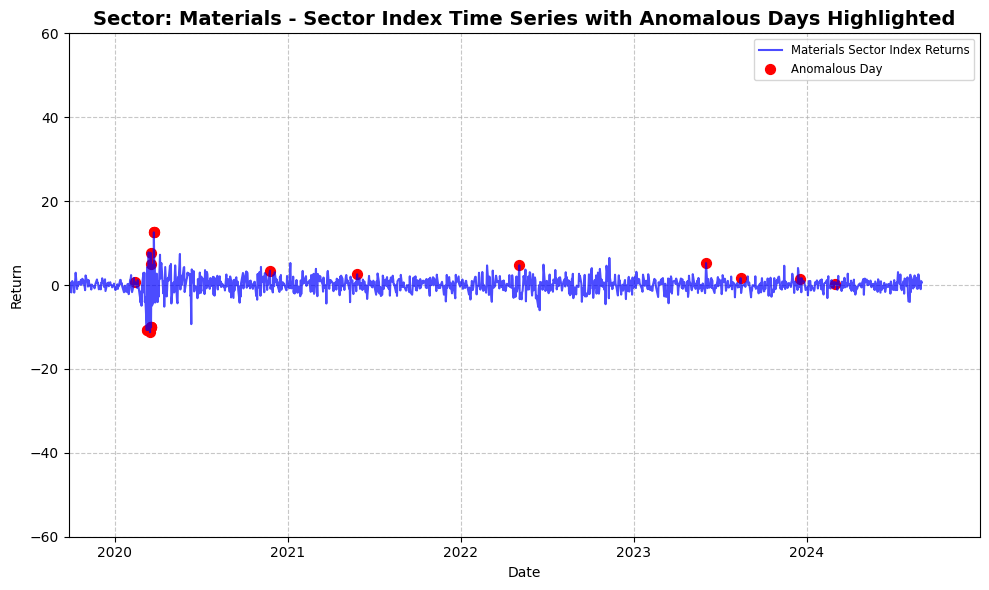

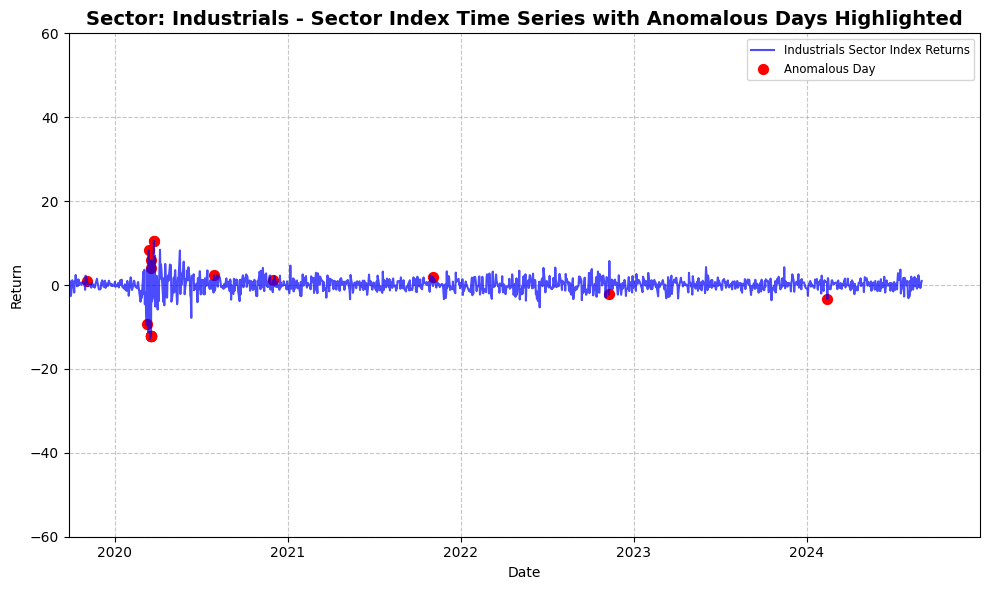

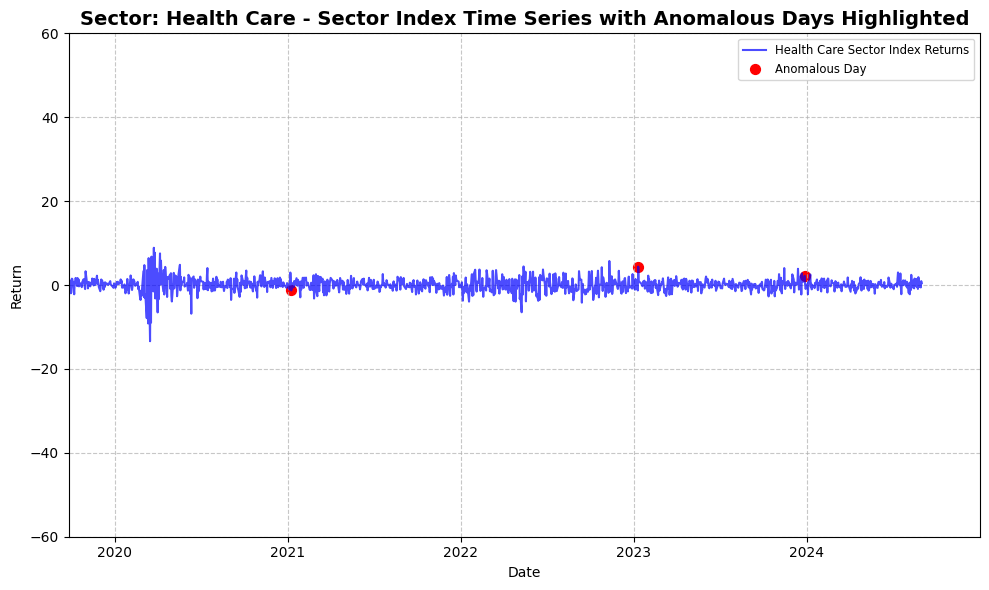

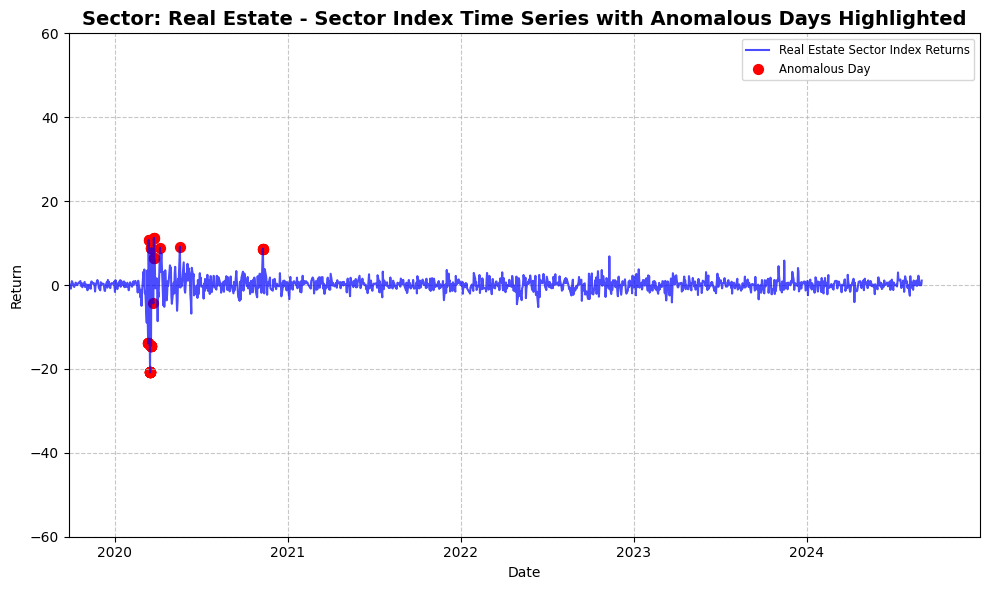

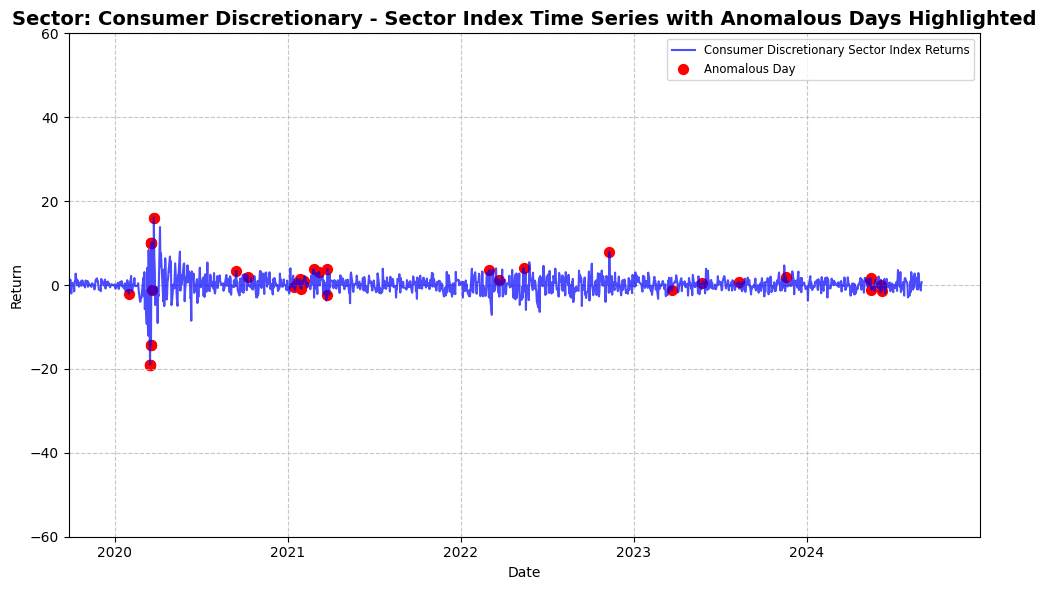

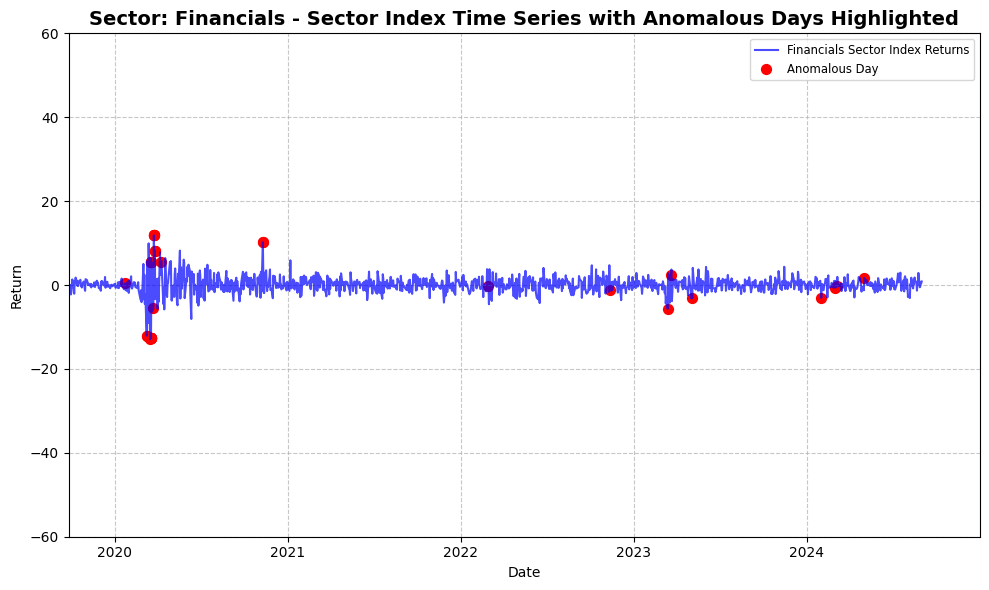

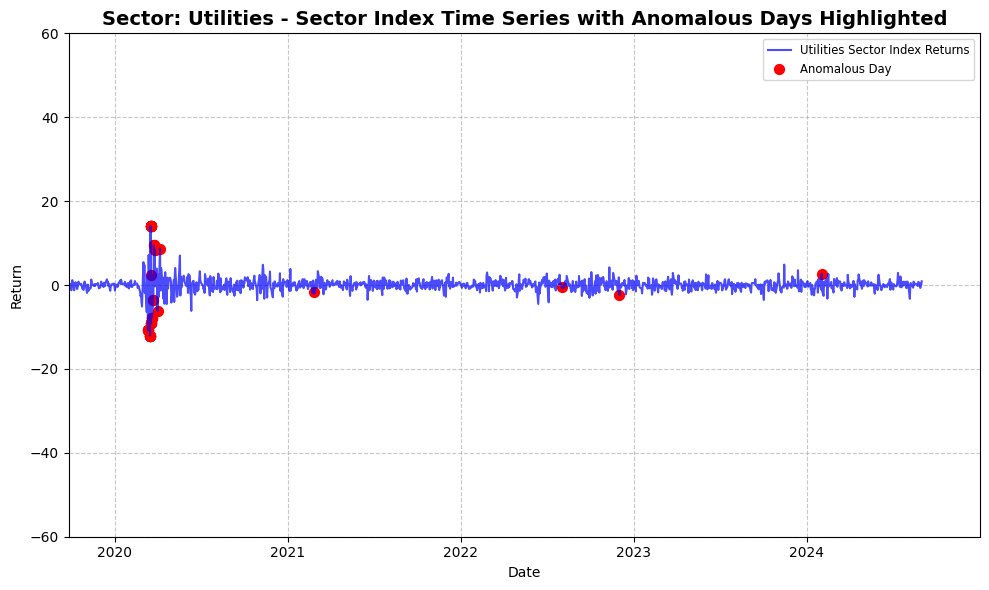

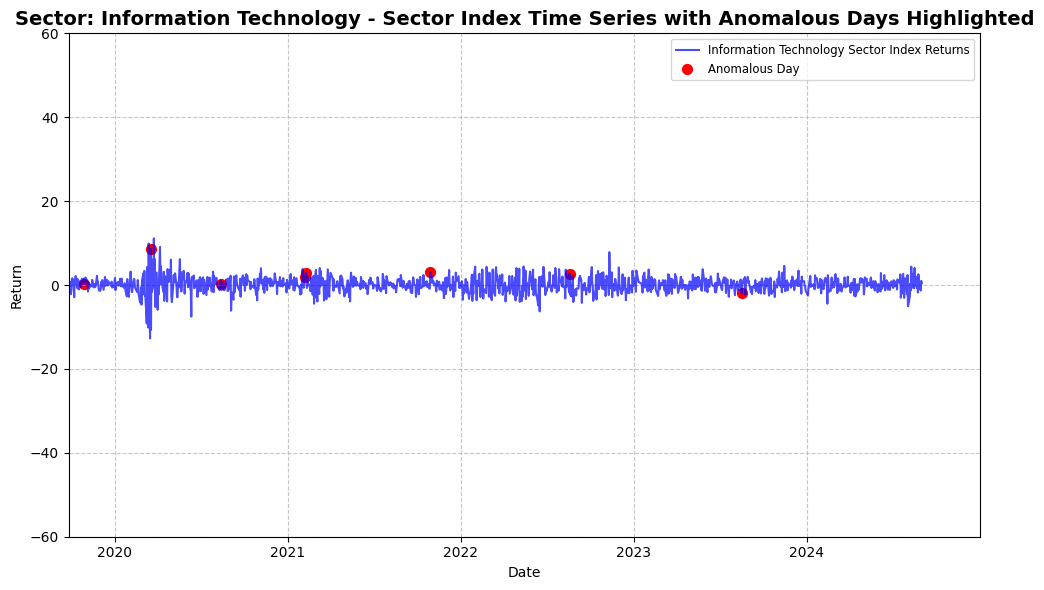

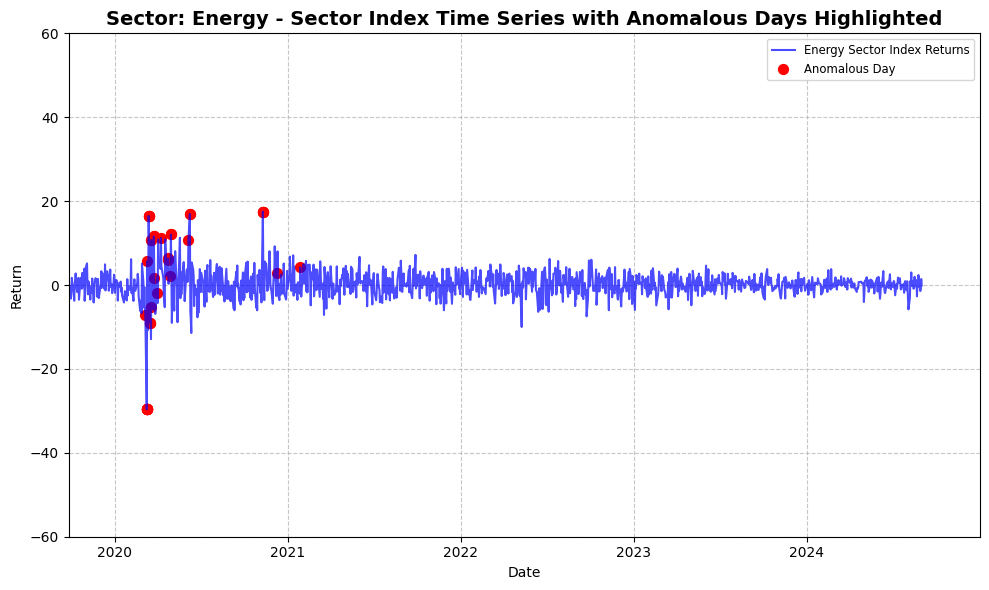

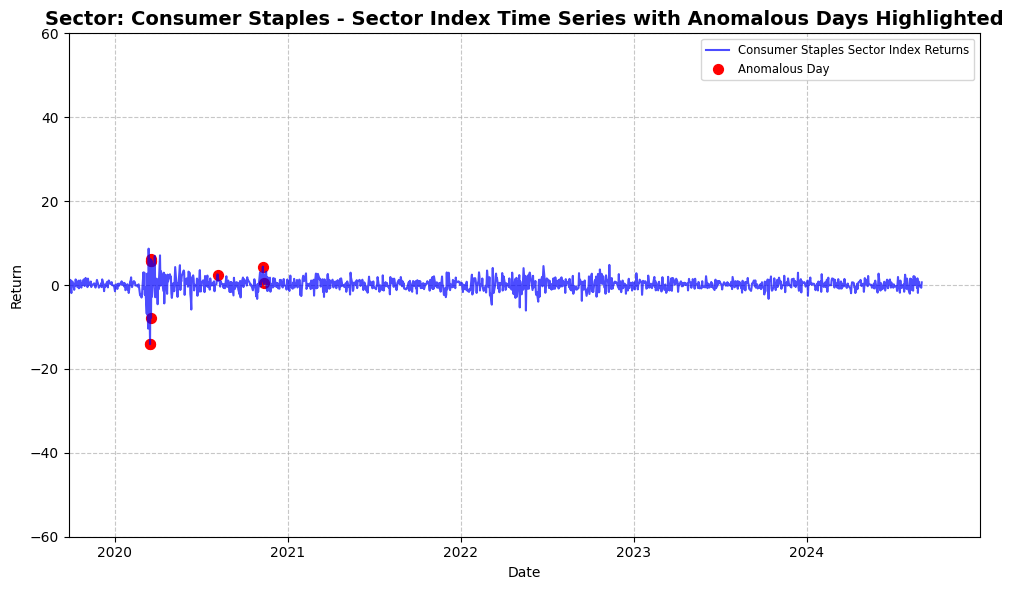

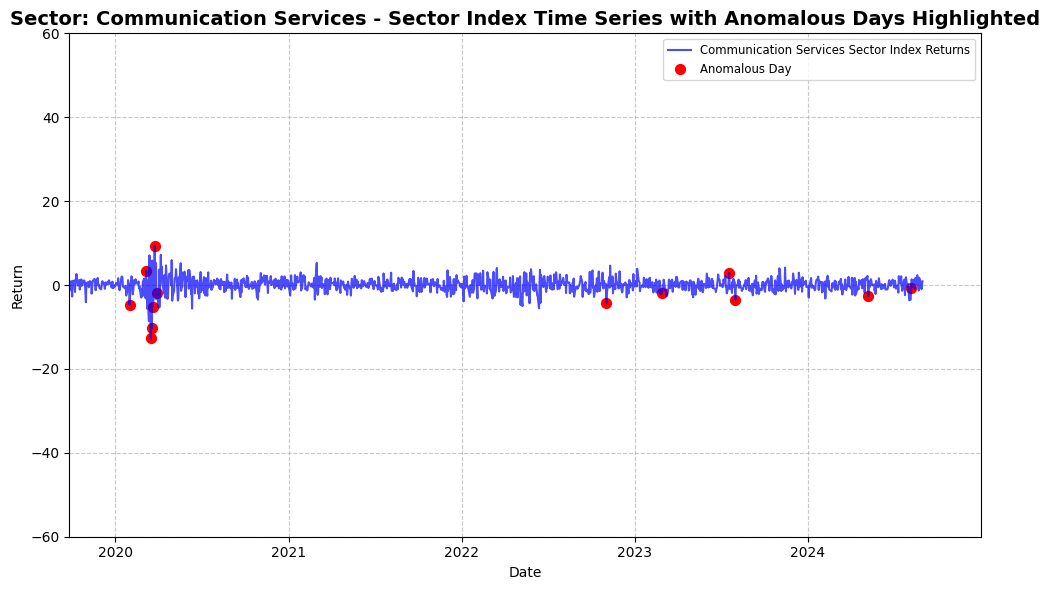

All anomalies across sectors (stock name, date, and anomaly score):

Sector: Materials
              date ticker  anomaly_score
1936052 2023-08-14      X      46.412533
153816  2020-03-18   AVNT      40.944420
153817  2020-03-19   AVNT      40.324855
286190  2024-02-29     CC      40.020549
60230   2021-05-27   ALTM      39.897995
60466   2022-05-04   ALTM      38.125237
5087    2020-03-24     AA      35.561706
1245904 2020-03-17    OLN      33.588118
1000838 2020-03-24    LPX      33.475995
1936140 2023-12-18      X      32.862421
355213  2020-03-18    CLF      30.860871
286004  2023-06-02     CC      30.332266
1871216 2020-03-09    WLK      30.266491
1432027 2020-03-24   RGLD      30.069550
285174  2020-02-14     CC      29.630799
1935370 2020-11-24      X      29.299164
282880  2020-03-18    CBT      29.137123
285189  2020-03-09     CC      28.987762
1432023 2020-03-18   RGLD      27.260198
163818  2020-03-16   AXTA      26.892214

Sector: Industrials
              date ticker  anom

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.spatial.distance import mahalanobis

# Ensure 'date' is in datetime format
df_merged['date'] = pd.to_datetime(df_merged['date'], errors='coerce')
df_merged.dropna(subset=['date'], inplace=True)

# Calculate daily returns for each stock
df_merged['return'] = df_merged.groupby('ticker')['adjusted_close'].pct_change() * 100
df_merged.dropna(subset=['return'], inplace=True)

# Define the exclusion period and the date filter for anomalies after 9/26/2019
exclusion_start = pd.Timestamp('2008-08-01')
exclusion_end = pd.Timestamp('2009-08-01')
date_filter_start = pd.Timestamp('2019-09-26')

# Function to calculate stable mean and covariance for the entire sector
def calculate_stable_mean_cov(sector_df):
    sector_returns = sector_df.pivot(index='date', columns='ticker', values='return').dropna()
    mean_vector = sector_returns.mean().values
    cov_matrix = np.cov(sector_returns.T)
    cov_inv = np.linalg.inv(cov_matrix)
    return mean_vector, cov_inv, sector_returns.columns

# Function to calculate anomalies using the stable mean and covariance across pairs
def calculate_multidimensional_anomalies(sector_df, mean_vector, cov_inv, sector_columns):
    anomalies = []

    for ticker in sector_columns:
        # Filter out the exclusion period
        ticker_df = sector_df[(sector_df['ticker'] == ticker) &
                              ~((sector_df['date'] >= exclusion_start) & (sector_df['date'] <= exclusion_end))].dropna(subset=['return'])

        if ticker_df.empty:
            continue  # Skip if no data for the ticker

        # Calculate Mahalanobis distance for each return against the stable sector mean
        ticker_df['anomaly_score'] = ticker_df['return'].apply(
            lambda x: mahalanobis([x], mean_vector, cov_inv)
        )

        anomalies.append(ticker_df[['date', 'ticker', 'anomaly_score']])

    # Combine all anomalies and sort by score
    all_anomalies = pd.concat(anomalies).sort_values(by='anomaly_score', ascending=False)

    # Select the top 70 highest anomalies
    top_anomalies = all_anomalies.nlargest(70, 'anomaly_score')

    return top_anomalies

# Prepare to collect anomalies for each sector
top_anomalies_per_sector = {}

# Calculate anomalies for each sector
for sector in df_merged['GICS Sector'].unique():
    sector_df = df_merged[df_merged['GICS Sector'] == sector].copy()
    stable_mean, stable_cov_inv, sector_columns = calculate_stable_mean_cov(sector_df)

    top_sector_anomalies = calculate_multidimensional_anomalies(sector_df, stable_mean, stable_cov_inv, sector_columns)
    # Filter to include only anomalies after 2019-09-26
    top_anomalies_per_sector[sector] = top_sector_anomalies[top_sector_anomalies['date'] >= date_filter_start]

# Create a date range covering only trading days after 2019-09-26 in the dataset
trading_days = df_merged[df_merged['date'] >= date_filter_start]['date'].unique()
trading_days = np.sort(pd.to_datetime(trading_days))  # Ensure dates are sorted

# Initialize an empty DataFrame for the sector-based anomaly summary
sector_anomalies_summary = pd.DataFrame(index=trading_days)

# Populate the DataFrame: 1 for anomaly, 0 for no anomaly
for sector, anomalies in top_anomalies_per_sector.items():
    # Mark anomalies for this sector as 1, non-anomalies as 0
    sector_anomalies_summary[sector] = 0
    anomaly_dates = anomalies['date'].unique()
    sector_anomalies_summary.loc[sector_anomalies_summary.index.isin(anomaly_dates), sector] = 1

# Save to CSV (only dates after 2019-09-26 will be included)
sector_anomalies_summary.to_csv("sector_anomalies_summary_mahalanobis_distance_filtered.csv")

# For Google Colab, you can add this to download the file directly
from google.colab import files
files.download("sector_anomalies_summary_mahalanobis_distance_filtered.csv")

# Plot each sector's time series and mark anomalies
for sector, top_anomalies in top_anomalies_per_sector.items():
    plt.figure(figsize=(10, 6))
    plt.title(f"Sector: {sector} - Sector Index Time Series with Anomalous Days Highlighted", fontsize=14, fontweight='bold')

    # Plot the sector's average daily return time series as a sector index
    sector_df = df_merged[df_merged['GICS Sector'] == sector].groupby('date')['return'].mean()
    plt.plot(sector_df.index, sector_df, color='blue', alpha=0.7, label=f'{sector} Sector Index Returns')

    # Highlight anomaly dates on the sector time series
    anomaly_dates = top_anomalies['date'].unique()  # Unique anomaly dates
    plt.scatter(top_anomalies['date'], sector_df.loc[top_anomalies['date']], color='red', s=50, label='Anomalous Day')

    # Customize each plot
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim([pd.Timestamp('2019-09-26'), pd.Timestamp('2024-12-31')])
    plt.ylim(-60, 60)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Add a legend
    plt.legend(loc='best', fontsize='small')

    # Adjust layout for neat spacing
    plt.tight_layout()
    plt.show()

# Display all anomalies with stock name, date, and anomaly score
print("All anomalies across sectors (stock name, date, and anomaly score):")
for sector, top_anomalies in top_anomalies_per_sector.items():
    print(f"\nSector: {sector}")
    print(top_anomalies)

# Message to confirm CSV generation
print("sector_anomalies_summary_mahalanobis_distance_filtered.csv has been created and saved.")


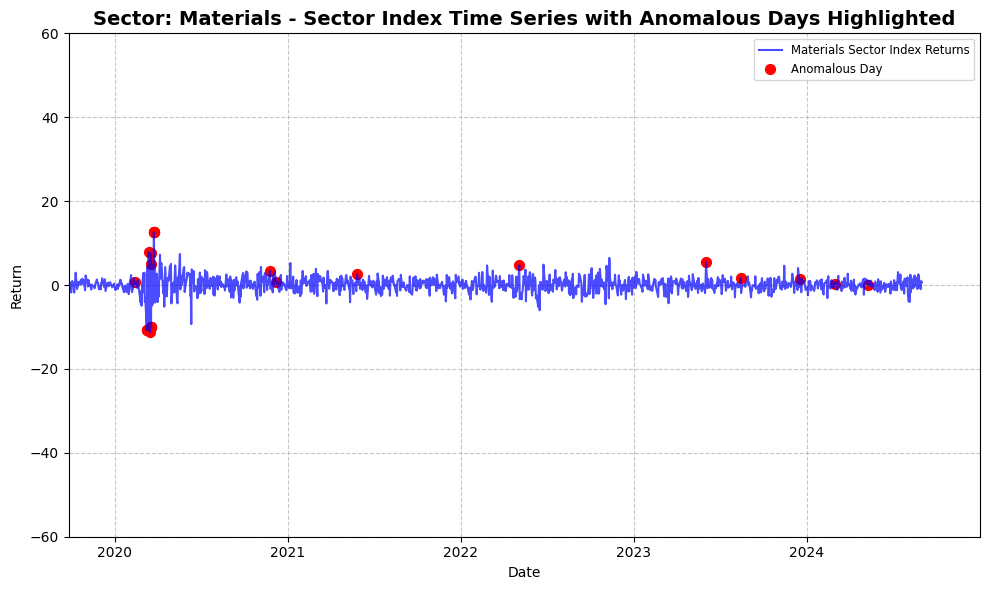

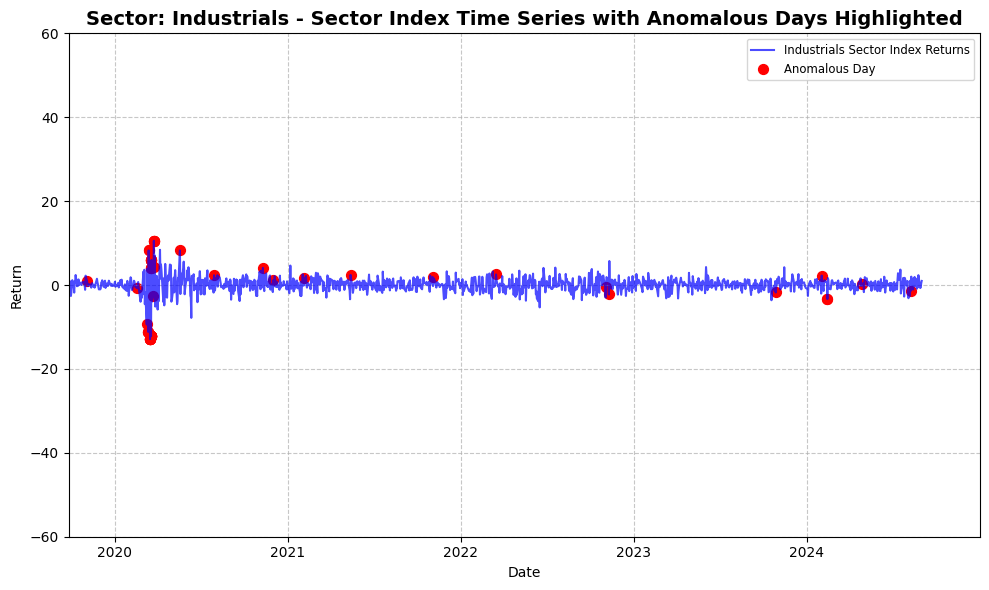

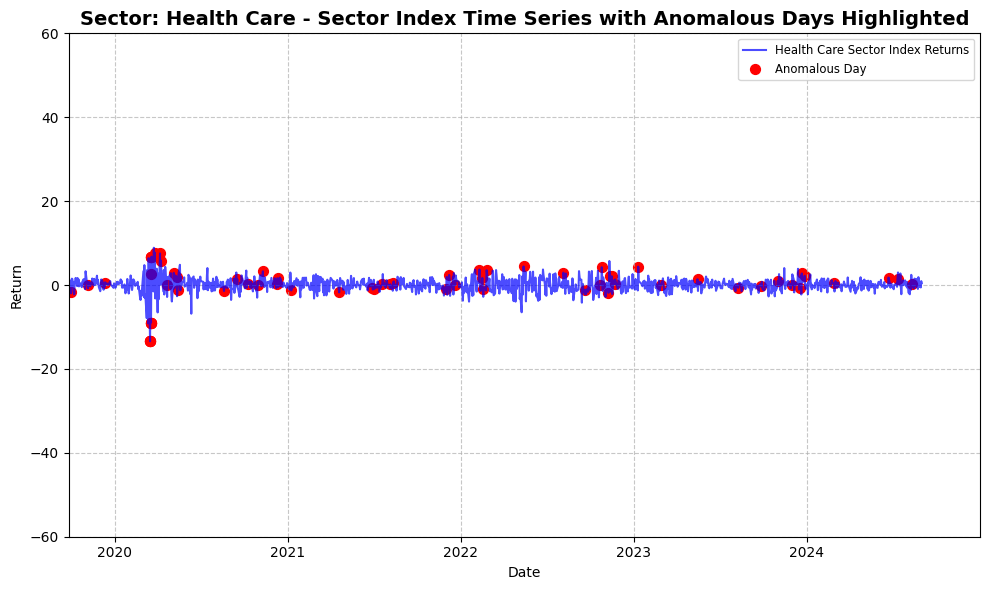

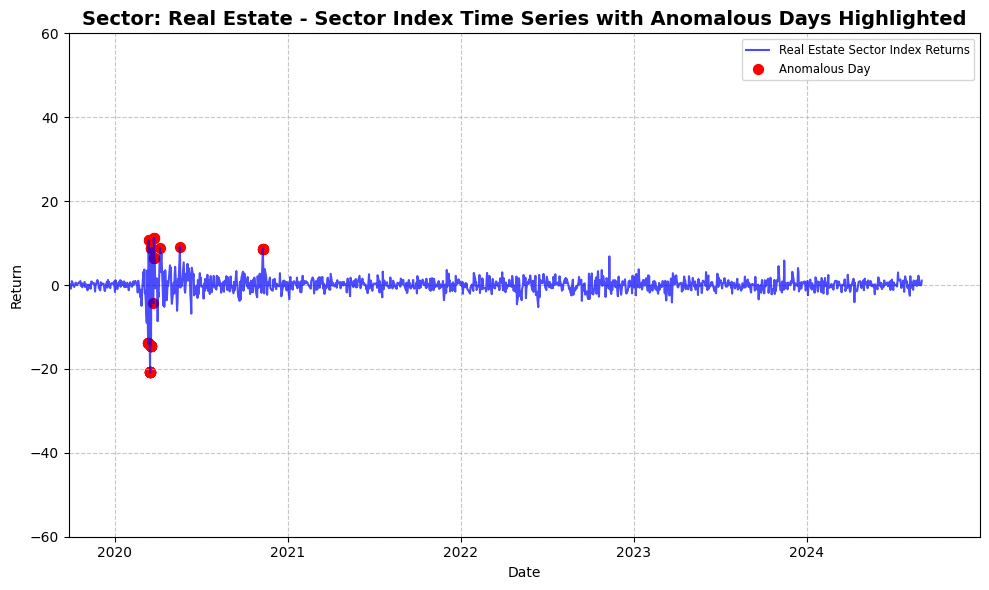

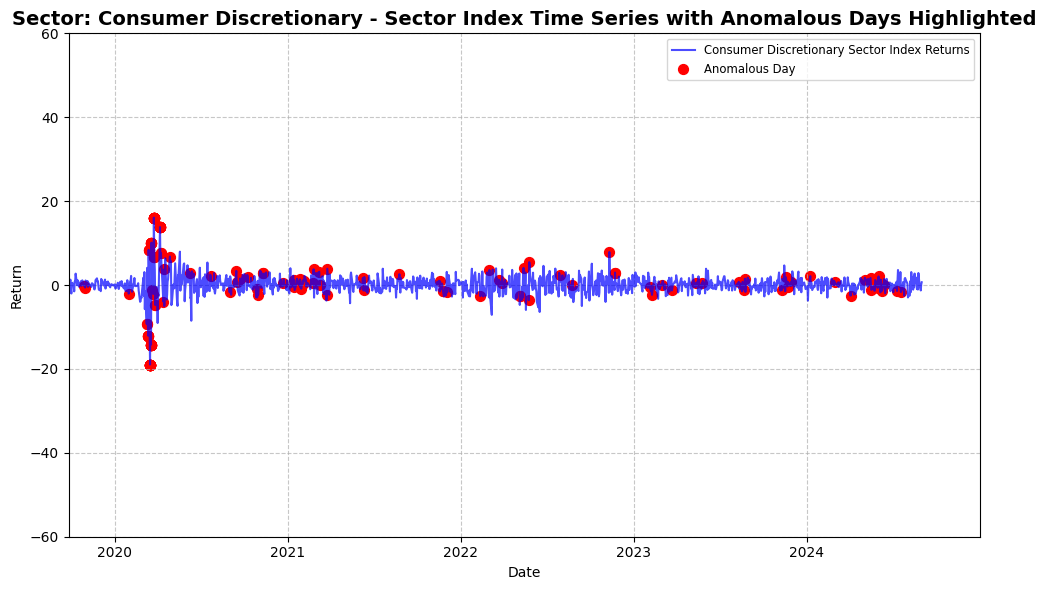

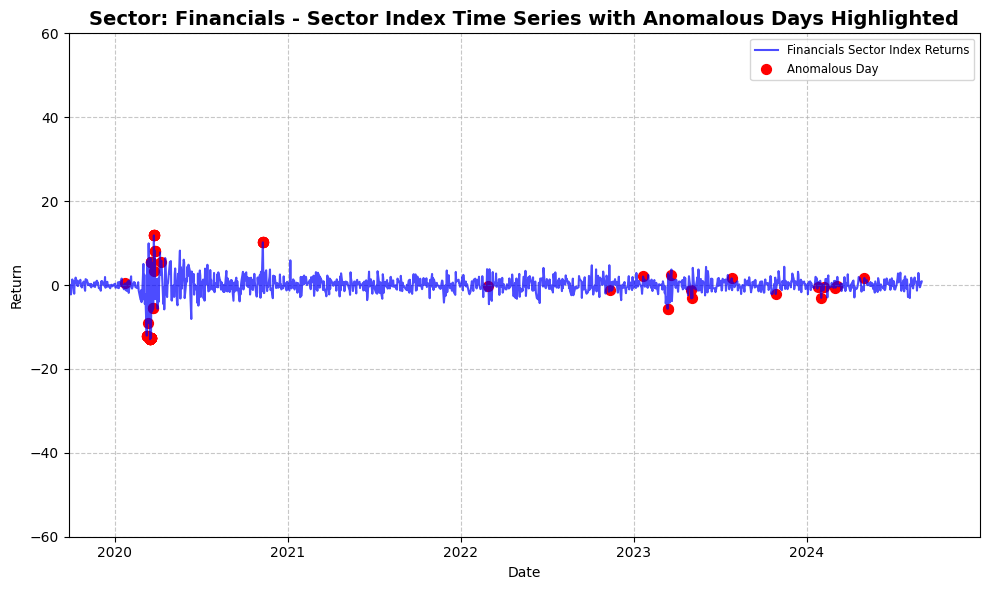

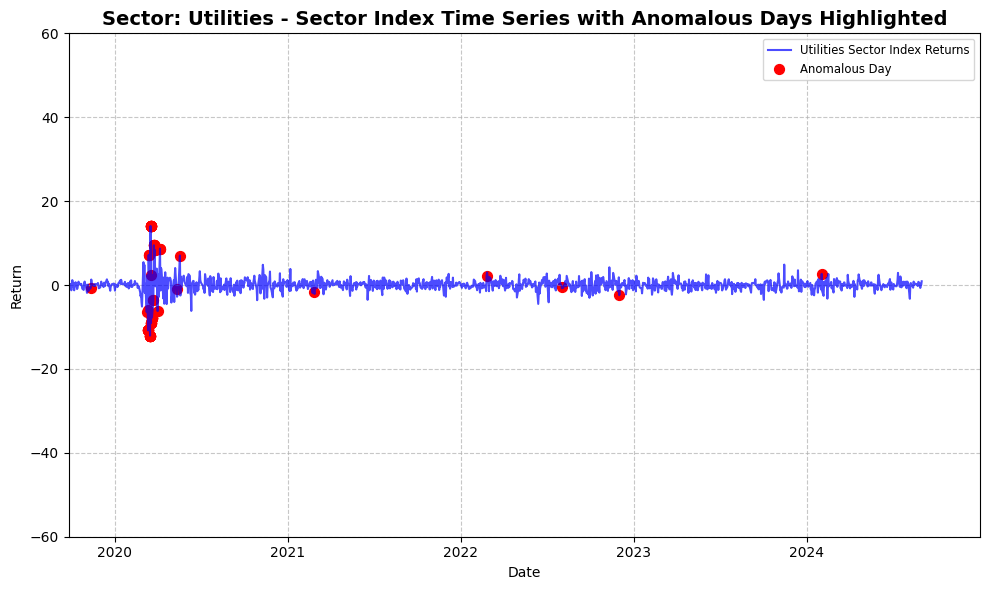

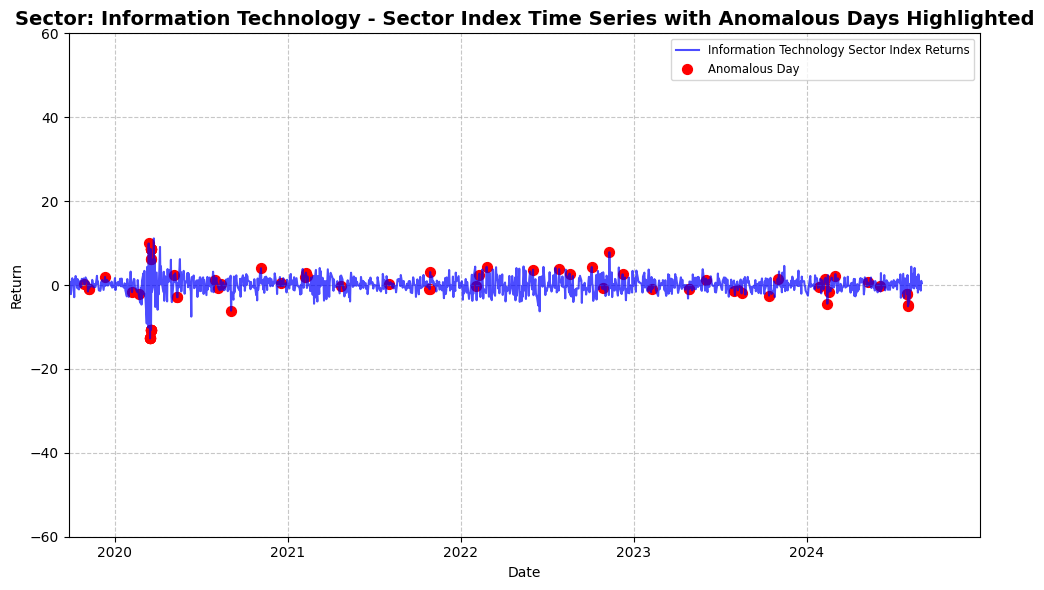

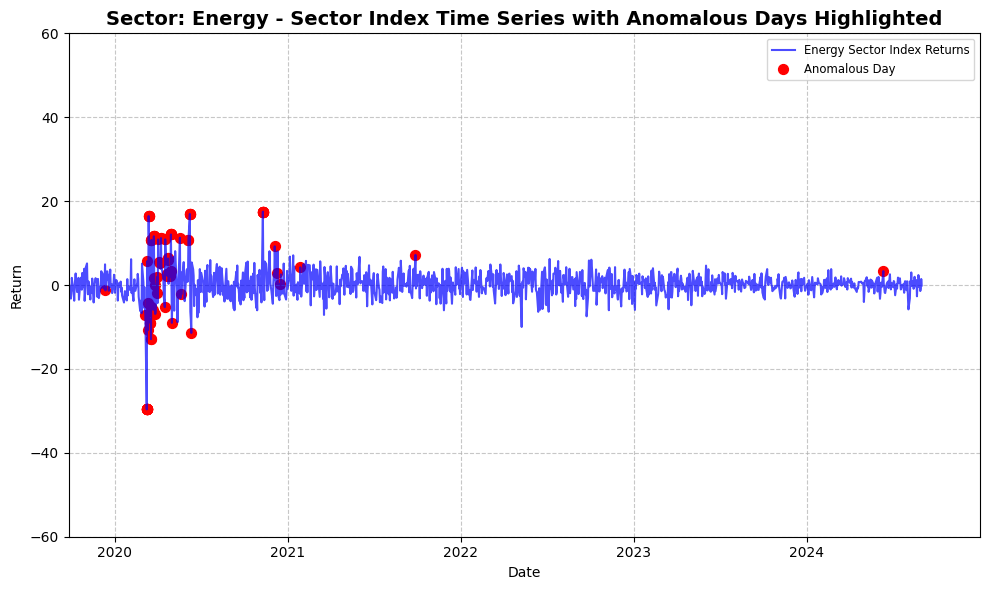

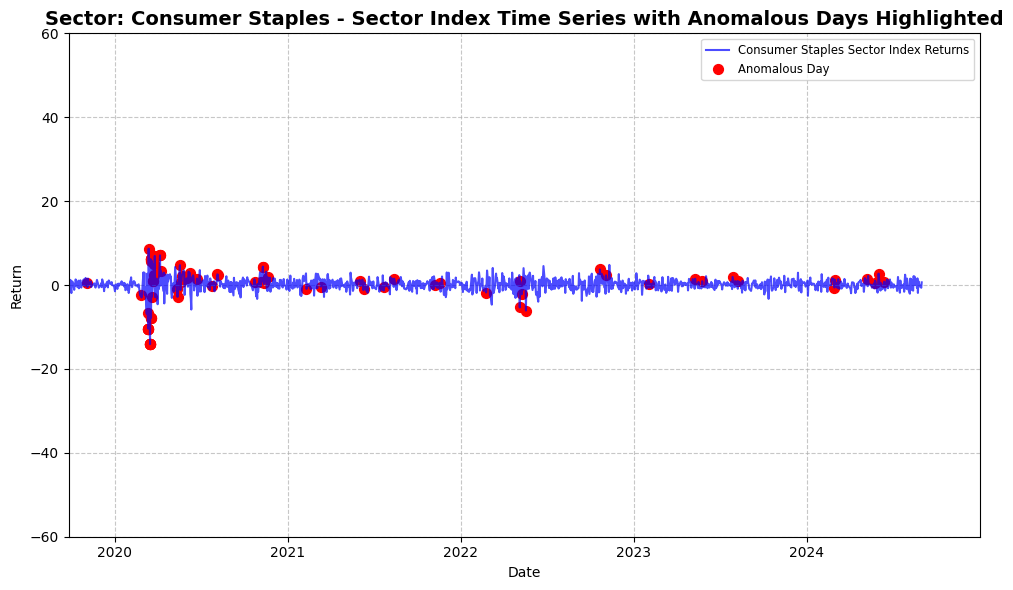

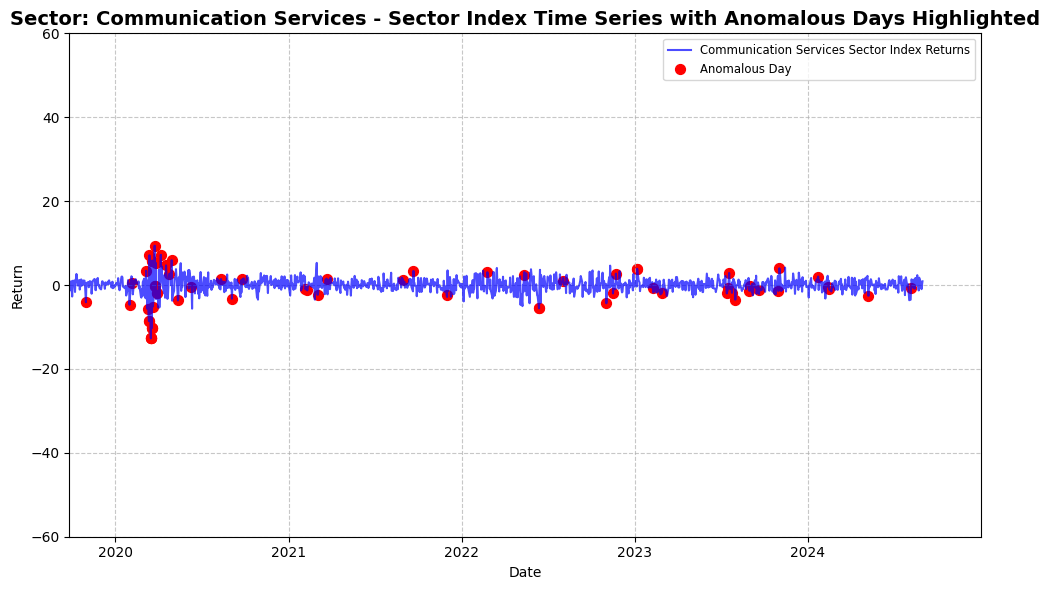

Anomalies data saved to 'all_anomalies_excluded_period.csv'.


In [13]:
# Define specific number of anomilies based on different sectors
#Materials count : 25
#Industrials count : 58
#Health Care count : 67
#Real Estate count : 53
#Consumer Discretionary count : 179
#Financials count : 78
#Utilities count : 76
#Information Technology count : 77
#Energy count : 82
#Consumer Staples count : 79
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.spatial.distance import mahalanobis

# Ensure 'date' is in datetime format
df_merged['date'] = pd.to_datetime(df_merged['date'], errors='coerce')
df_merged.dropna(subset=['date'], inplace=True)

# Filter data to start from 2019-09-26
start_date = pd.Timestamp('2019-09-26')
df_merged = df_merged[df_merged['date'] >= start_date]

# Calculate daily returns for each stock
df_merged['return'] = df_merged.groupby('ticker')['adjusted_close'].pct_change() * 100
df_merged.dropna(subset=['return'], inplace=True)

# Function to calculate stable mean and covariance for the entire sector
def calculate_stable_mean_cov(sector_df):
    sector_returns = sector_df.pivot(index='date', columns='ticker', values='return').dropna()
    mean_vector = sector_returns.mean().values
    cov_matrix = np.cov(sector_returns.T)
    cov_inv = np.linalg.inv(cov_matrix)
    return mean_vector, cov_inv, sector_returns.columns

# Function to calculate anomalies using the stable mean and covariance across pairs
def calculate_multidimensional_anomalies(sector_df, mean_vector, cov_inv, sector_columns, top_count):
    anomalies = []

    for ticker in sector_columns:
        # Filter out the exclusion period
        ticker_df = sector_df[(sector_df['ticker'] == ticker)].dropna(subset=['return'])

        if ticker_df.empty:
            continue  # Skip if no data for the ticker

        # Calculate Mahalanobis distance for each return against the stable sector mean
        ticker_df['anomaly_score'] = ticker_df['return'].apply(
            lambda x: mahalanobis([x], mean_vector, cov_inv)
        )

        anomalies.append(ticker_df[['date', 'ticker', 'anomaly_score']])

    # Combine all anomalies and sort by score
    all_anomalies = pd.concat(anomalies).sort_values(by='anomaly_score', ascending=False)

    # Select the specified top anomalies
    top_anomalies = all_anomalies.nlargest(top_count, 'anomaly_score')

    return top_anomalies

# Define the required number of anomalies for each sector
sector_anomalies_count = {
    "Materials": 25,
    "Industrials": 58,
    "Health Care": 67,
    "Real Estate": 53,
    "Consumer Discretionary": 179,
    "Financials": 78,
    "Utilities": 76,
    "Information Technology": 77,
    "Energy": 82,
    "Consumer Staples": 79,
    "Communication Services": 67
}

# Prepare to collect anomalies for plotting and final output
top_anomalies_per_sector = {}

# Calculate anomalies for each sector by analyzing stock pairs
for sector in df_merged['GICS Sector'].unique():
    sector_df = df_merged[df_merged['GICS Sector'] == sector].copy()
    stable_mean, stable_cov_inv, sector_columns = calculate_stable_mean_cov(sector_df)

    # Use the specified count for this sector
    top_count = sector_anomalies_count.get(sector, 50)  # Default to 50 if sector not in the dictionary
    top_sector_anomalies = calculate_multidimensional_anomalies(sector_df, stable_mean, stable_cov_inv, sector_columns, top_count)
    top_anomalies_per_sector[sector] = top_sector_anomalies  # Store top anomalies for this sector

# Save all anomalies to a CSV file
all_anomalies_combined = pd.concat(top_anomalies_per_sector.values())
all_anomalies_combined.to_csv("all_anomalies_excluded_period.csv", index=False)

# Plot each sector's time series and mark anomalies
for sector, top_anomalies in top_anomalies_per_sector.items():
    plt.figure(figsize=(10, 6))
    plt.title(f"Sector: {sector} - Sector Index Time Series with Anomalous Days Highlighted", fontsize=14, fontweight='bold')

    # Plot the sector's average daily return time series as a sector index
    sector_df = df_merged[df_merged['GICS Sector'] == sector]
    sector_daily_returns = sector_df.pivot_table(index='date', values='return', aggfunc='mean')
    plt.plot(sector_daily_returns.index, sector_daily_returns['return'], color='blue', alpha=0.7, label=f'{sector} Sector Index Returns')

    # Highlight anomaly dates on the sector time series
    anomaly_dates = top_anomalies['date'].unique()  # Unique anomaly dates
    anomaly_scores = top_anomalies[top_anomalies['date'].isin(anomaly_dates)]
    plt.scatter(anomaly_scores['date'], sector_daily_returns.loc[anomaly_scores['date'], 'return'], color='red', s=50, label='Anomalous Day')

    # Customize each plot
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim([start_date, pd.Timestamp('2024-12-31')])
    plt.ylim(-60, 60)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Add a legend
    plt.legend(loc='best', fontsize='small')

    # Adjust layout for neat spacing
    plt.tight_layout()
    plt.show()

# Display a message to inform the user
print("Anomalies data saved to 'all_anomalies_excluded_period.csv'.")

In [14]:
from google.colab import files

# Save the combined anomalies to a CSV file
output_file = "all_anomalies_excluded_period.csv"
all_anomalies_combined.to_csv(output_file, index=False)

# Download the file
files.download(output_file)

print(f"Anomalies data saved and available for download as '{output_file}'.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Anomalies data saved and available for download as 'all_anomalies_excluded_period.csv'.
